# Part #2 of Phase #2 - Heuristic LV Segmentation Approaches

## Introduction

The purpose of this task is to create a system that provides an outline or delineate the boundary of the blood pool denoted by the *i-contours* given that we only know the outer border of the heart muscle denoted by the *o-contours*.

As a first approach, a more heuristic method will be sought out to provide a baseline performance to be compared with other more sophisticated approaches (such as using deep learning).  To make things easier, what we'll do is compute the actual **mask** that encompasses the interior of each type of contour and one can simply extract the perimeter of the contour to get the outline.

## Comparison of intensity profiles of those inside the blood pool to those inside the heart muscle

To see what we're dealing with, the first step we'll perform is to compare the intensity profile of the region inside the blood pool, or internal to the boundary provided by the *i-contour* to those inside the heart muscle, or the area in between the *o-contour* and *i-contour*.

First let's load in the necessary packges that we need to use to perform our analysis.  Because we are dealing with intensities in images, we will opt to use the very popular [scikit-image](http://scikit-image.org/) framework.  To perform additional boosts in performance, we'll borrow one function from the morphology suite from [SciPy](https://www.scipy.org/).  [OpenCV](https://opencv.org/) is another option but is quite cumbersome to build and compile without the right dependencies.  scikit-image (and of course SciPy) is conveniently available through the [Python Package Index](https://pypi.org/project/scikit-image/) and builds on top of SciPy.

In [1]:
from dicom_loader import DICOMLoader # Code from the challenge

from skimage.filters import threshold_otsu # For Otsu thresholding
from skimage.measure import label, regionprops # For measuring statistics of blobs
from skimage.morphology import binary_erosion # For morphological erosion

from scipy.ndimage.morphology import binary_fill_holes # For hole filling

import numpy as np # Just because!

import matplotlib.pyplot as plt # To show images

import tabulate # For displaying tables

from IPython.display import HTML, display # For displaying tables in the notebook

# To show inside the notebook
%matplotlib inline

/home/sahand/anaconda3/envs/medical/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In this study, it should be noted that each patient will have different characteristics.  Therefore, it is prudent to perform this intensity profile comparison on each patient separately rather than collectively as a single batch of data.  This is so that heuristics could potentially be performed on a per patient basis to be tailored towards the particular patient.  Mind you, this is not very ideal if one desires to do this in a more adaptive approach, but the reason why this is particularly useful in this context is because there is one set of *i-contour* and *o-contour* data that was received as part of this challenge that appears to be quite inaccurate.  This dataset was found in directory *SC-HF-I-6* corresponding to patient ID SCD0000501 for the DICOM image data.  In particular, the delineation of the *o-contour* is not quite a superset of the *i-contour* and there are regions that have no overlap.  This I believe is an error in either the data or the demarcation of the contour points made by the clinician.

In any case, let's have a look intensity profile from the blood pool and those inside the heart muscle for each patient individually.

Patient ID: SCD0000101
DICOM Image: data/dicoms/SCD0000101/159.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0159-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0159-ocontour-manual.txt


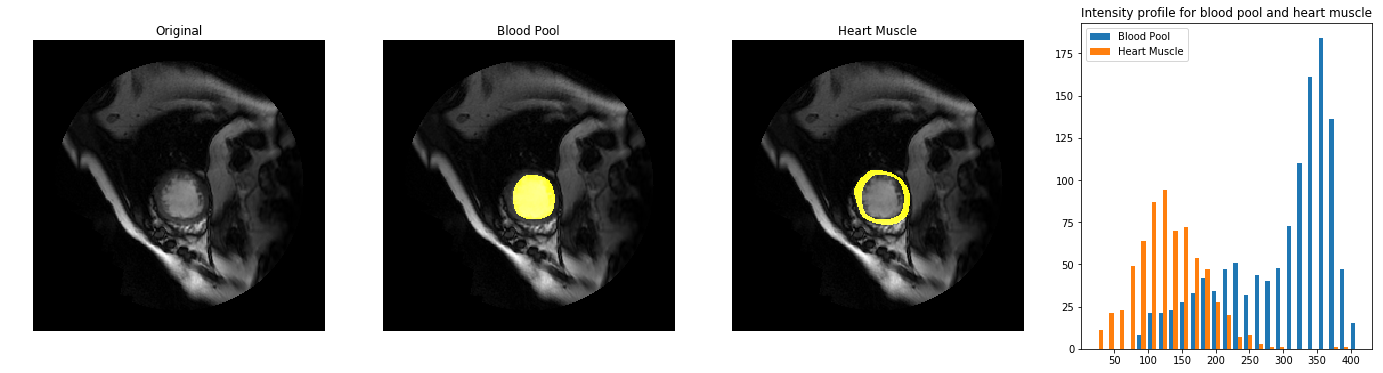

DICOM Image: data/dicoms/SCD0000101/99.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0099-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0099-ocontour-manual.txt


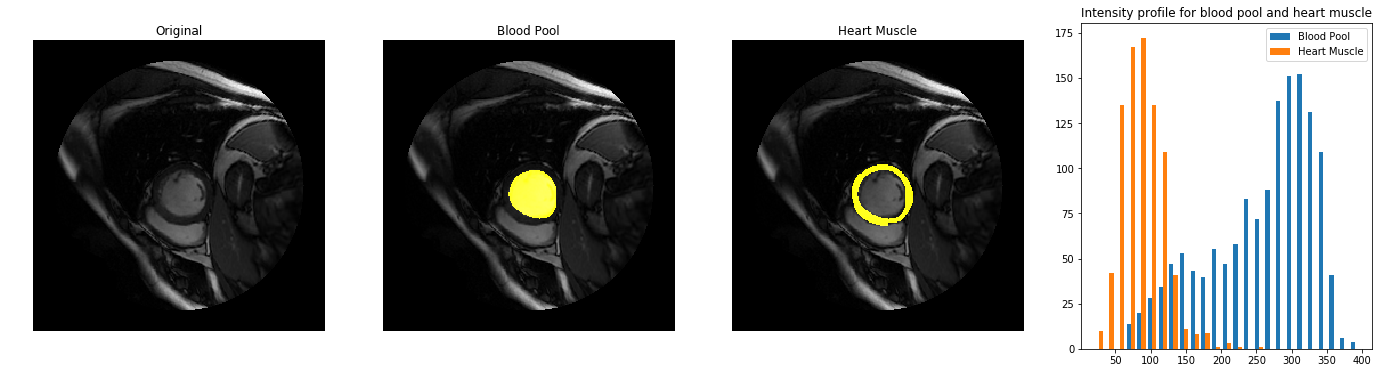

DICOM Image: data/dicoms/SCD0000101/119.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0119-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0119-ocontour-manual.txt


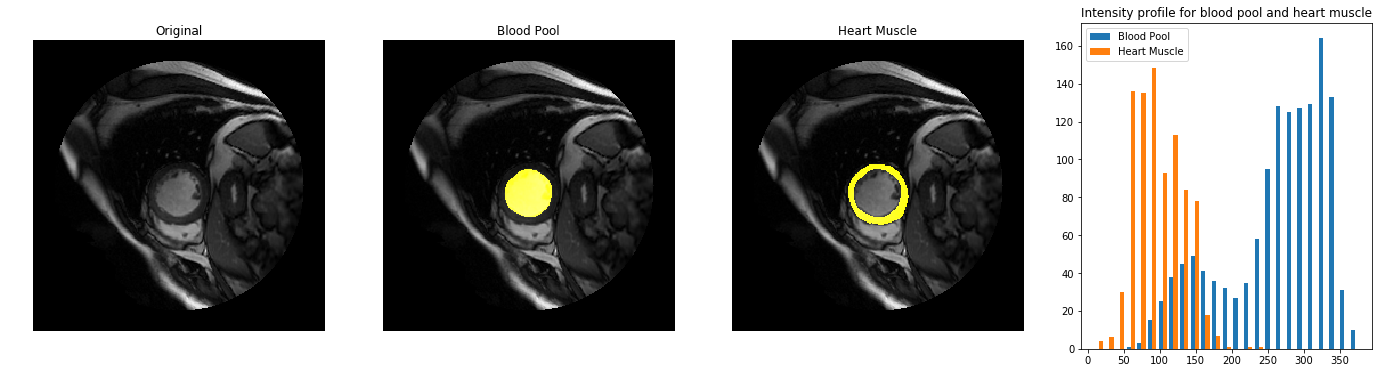

DICOM Image: data/dicoms/SCD0000101/139.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0139-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0139-ocontour-manual.txt


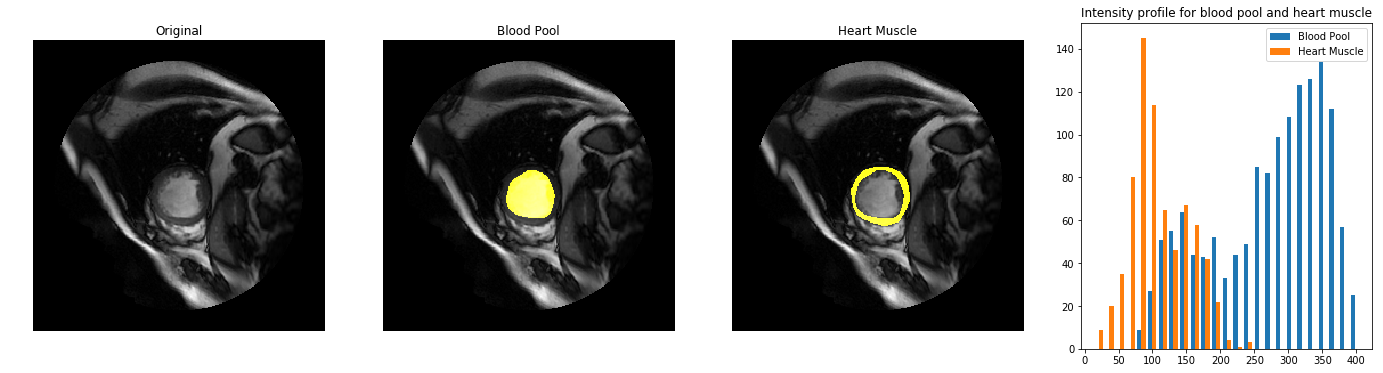

DICOM Image: data/dicoms/SCD0000101/219.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0219-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0219-ocontour-manual.txt


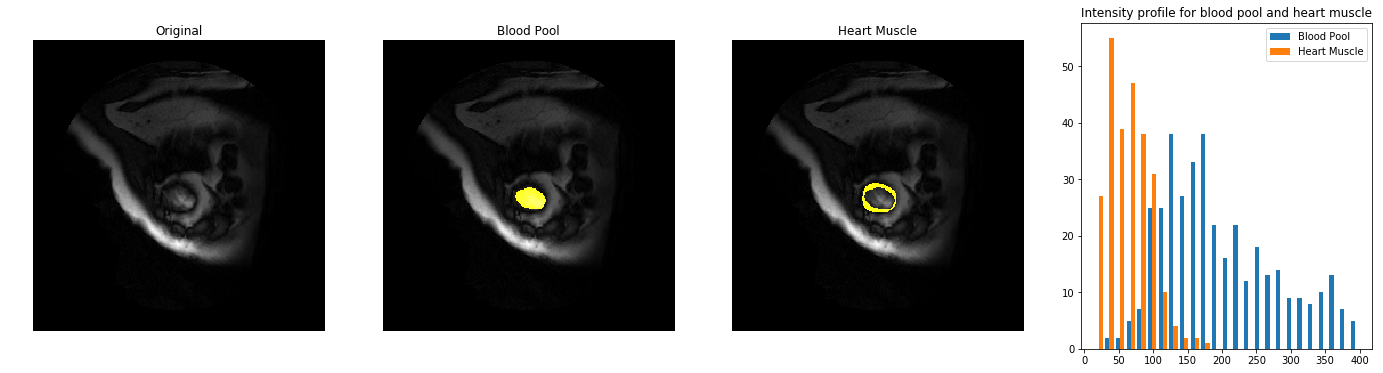

DICOM Image: data/dicoms/SCD0000101/179.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0179-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0179-ocontour-manual.txt


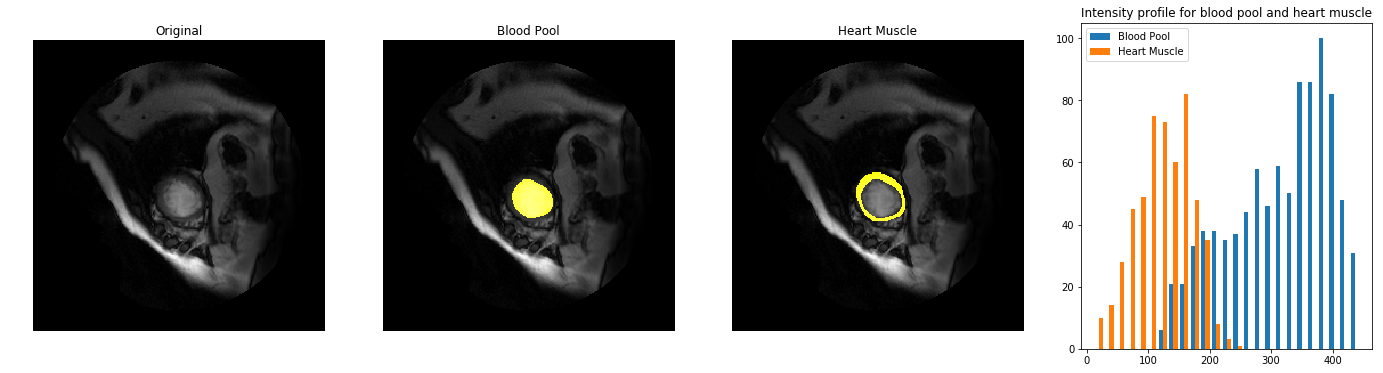

DICOM Image: data/dicoms/SCD0000101/199.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0199-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0199-ocontour-manual.txt


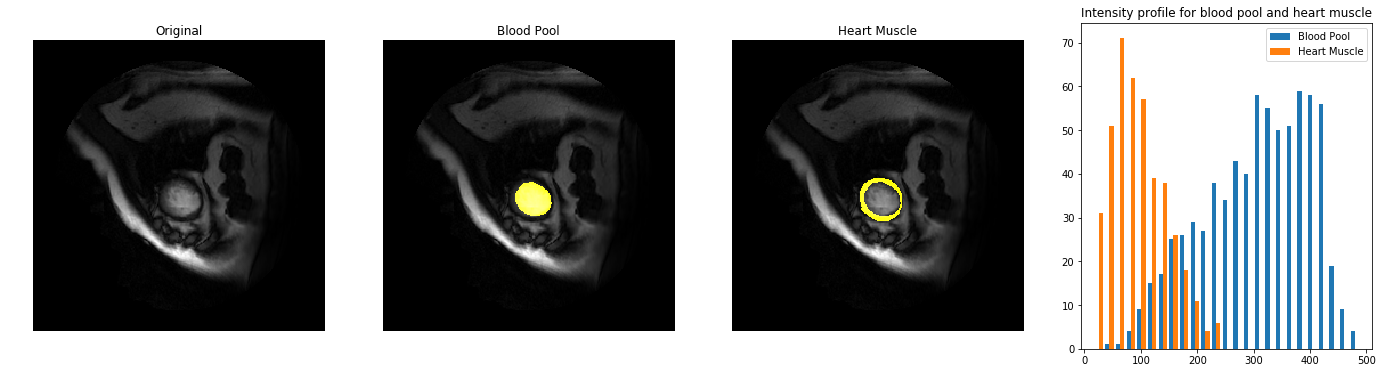

DICOM Image: data/dicoms/SCD0000101/59.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0059-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0059-ocontour-manual.txt


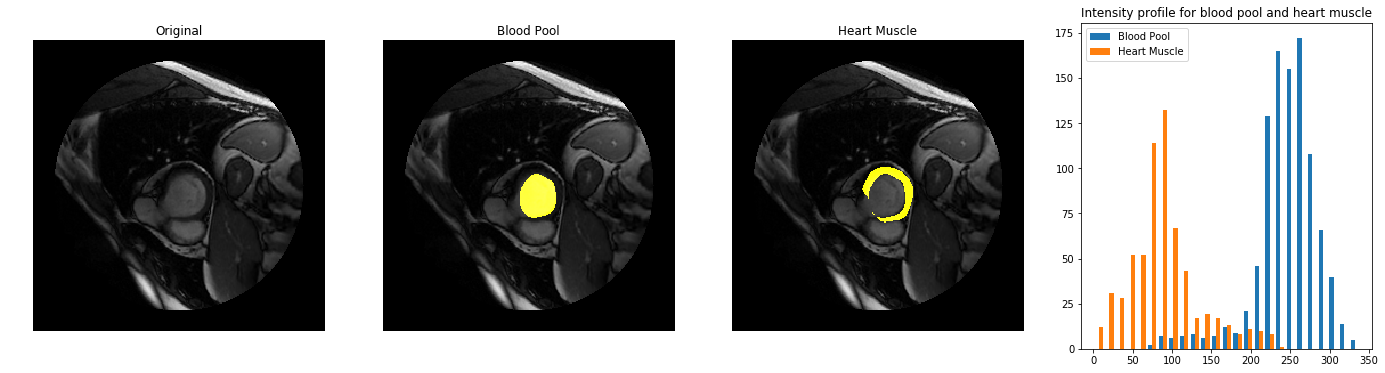

DICOM Image: data/dicoms/SCD0000101/79.dcm
i-contour mask file: data/contourfiles/SC-HF-I-1/i-contours/IM-0001-0079-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-1/o-contours/IM-0001-0079-ocontour-manual.txt


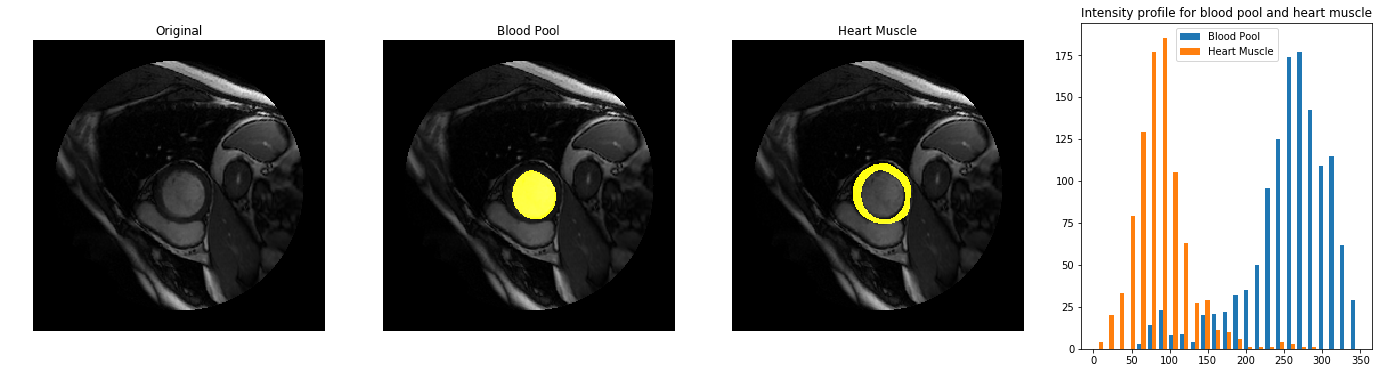

Patient ID: SCD0000201
DICOM Image: data/dicoms/SCD0000201/120.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0120-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0120-ocontour-manual.txt


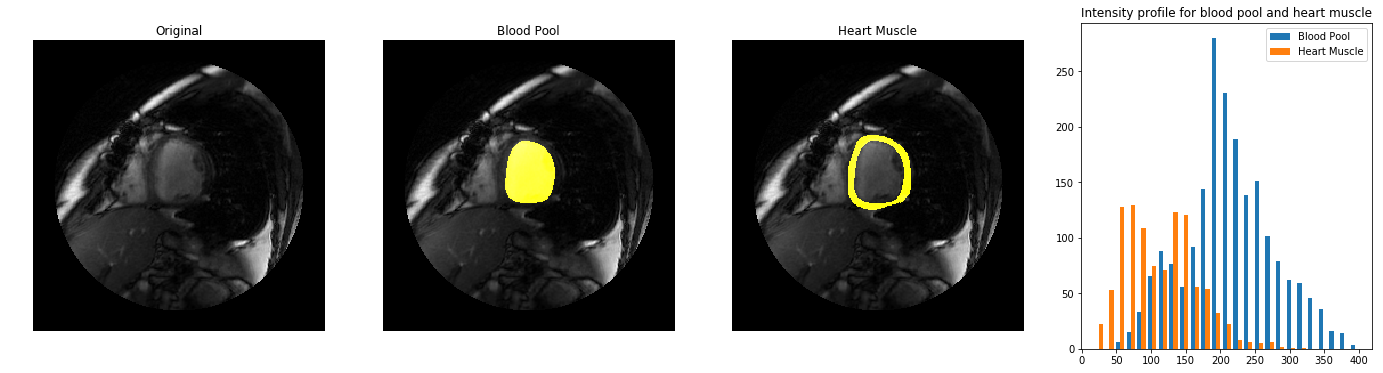

DICOM Image: data/dicoms/SCD0000201/140.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0140-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0140-ocontour-manual.txt


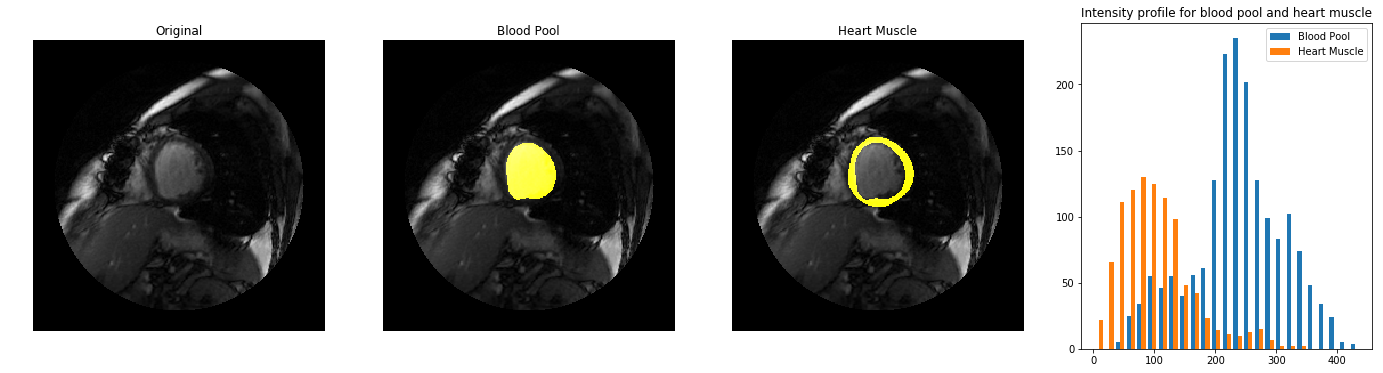

DICOM Image: data/dicoms/SCD0000201/220.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0220-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0220-ocontour-manual.txt


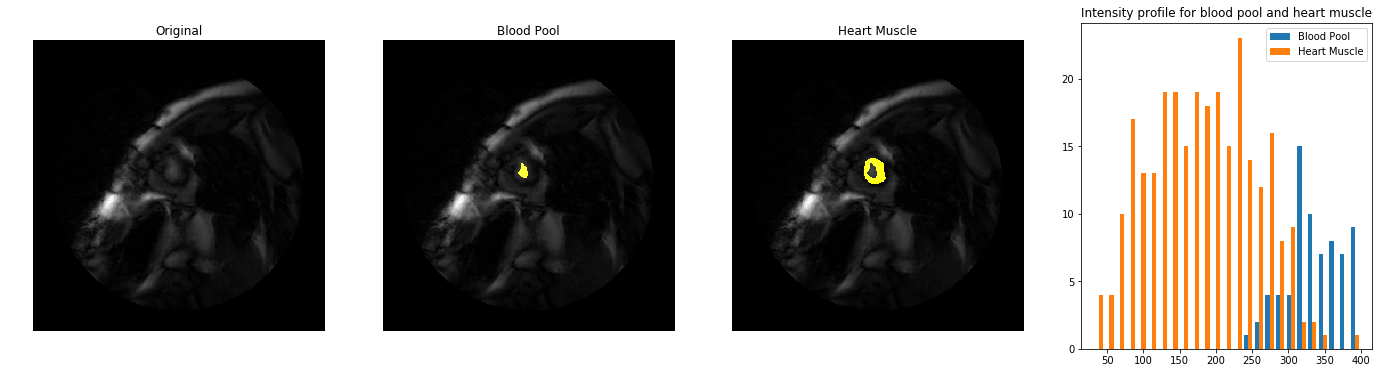

DICOM Image: data/dicoms/SCD0000201/100.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0100-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0100-ocontour-manual.txt


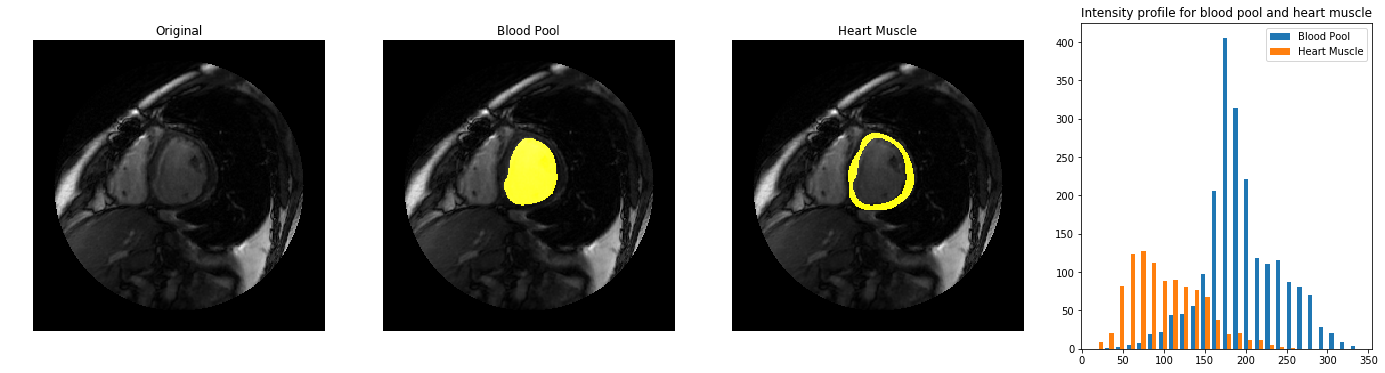

DICOM Image: data/dicoms/SCD0000201/200.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0200-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0200-ocontour-manual.txt


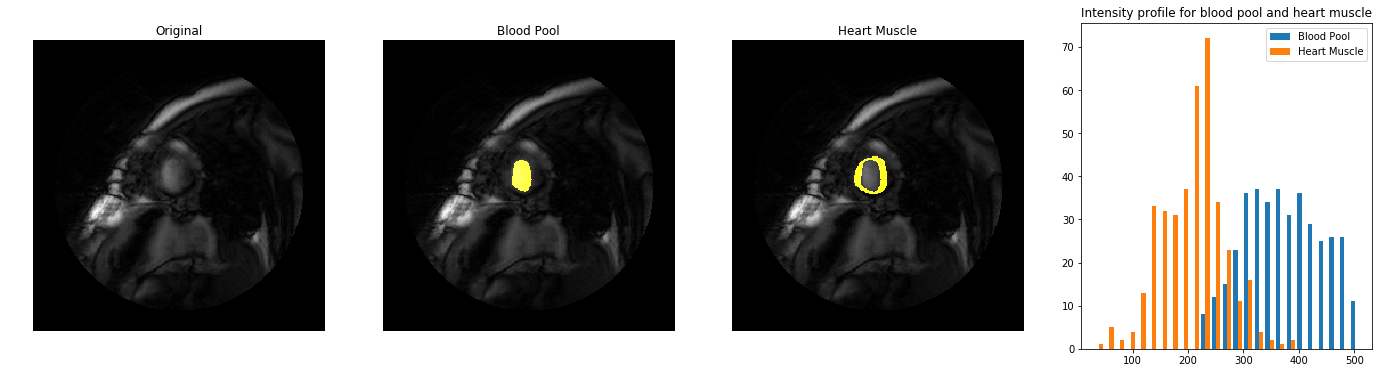

DICOM Image: data/dicoms/SCD0000201/180.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0180-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0180-ocontour-manual.txt


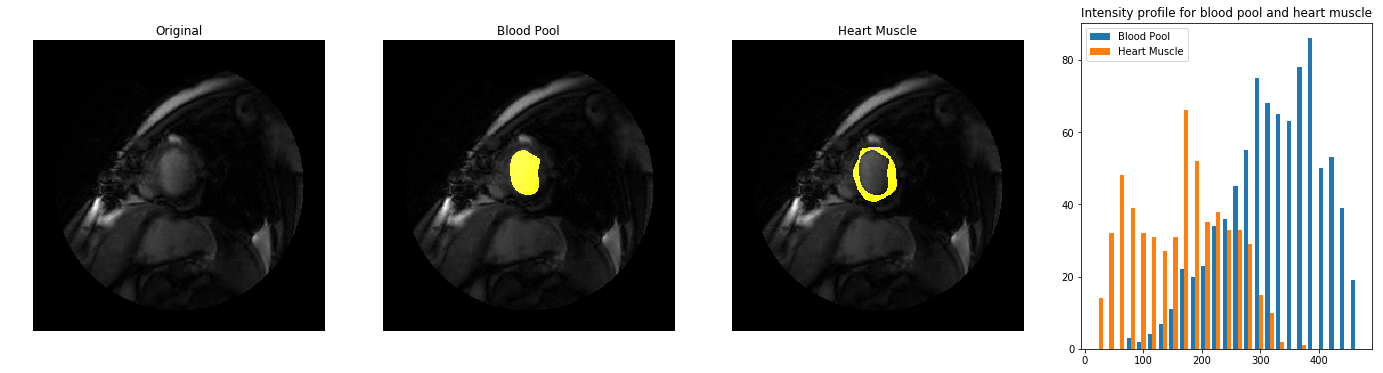

DICOM Image: data/dicoms/SCD0000201/80.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0080-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0080-ocontour-manual.txt


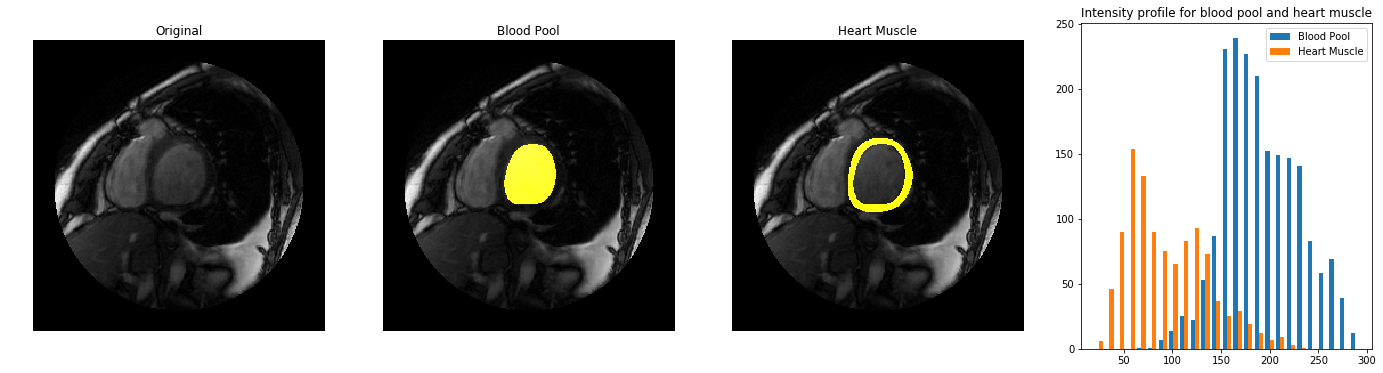

DICOM Image: data/dicoms/SCD0000201/60.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0060-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0060-ocontour-manual.txt


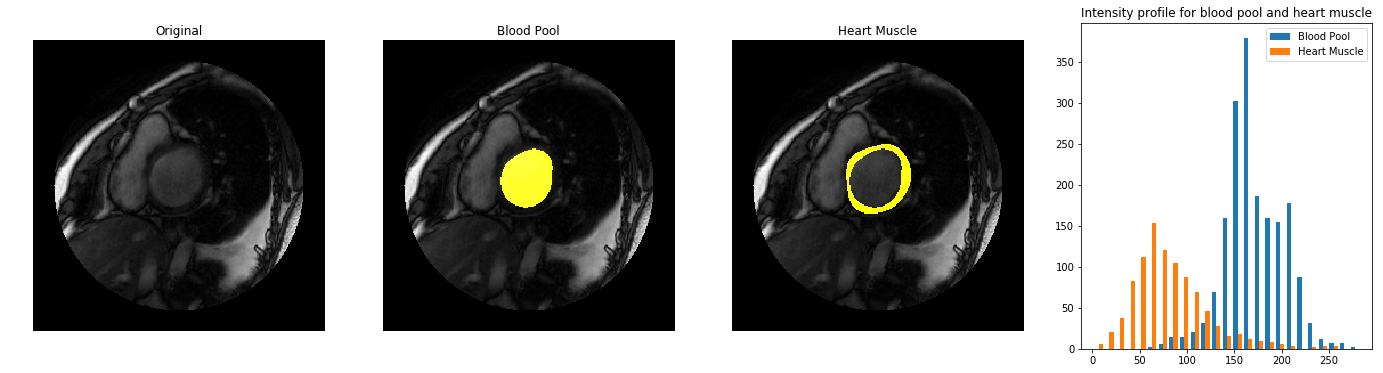

DICOM Image: data/dicoms/SCD0000201/160.dcm
i-contour mask file: data/contourfiles/SC-HF-I-2/i-contours/IM-0001-0160-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-2/o-contours/IM-0001-0160-ocontour-manual.txt


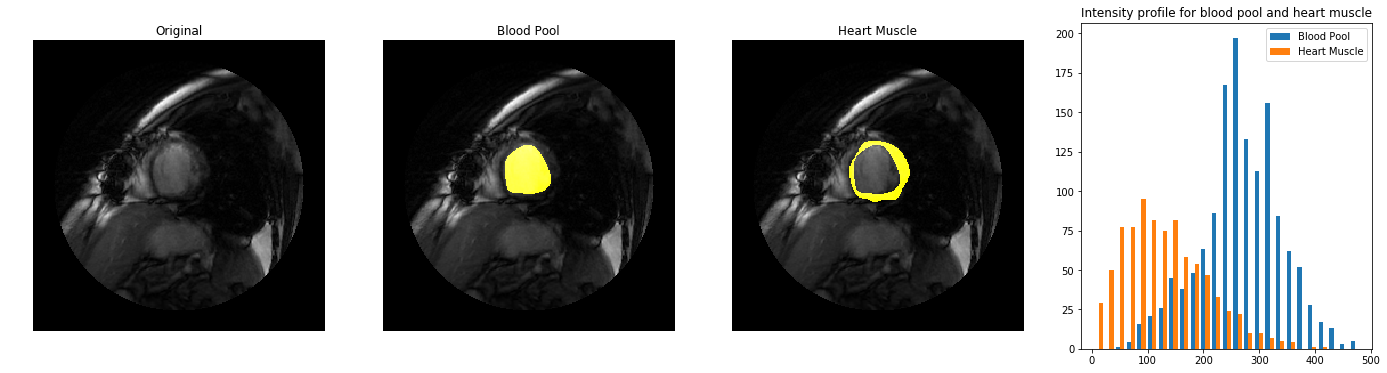

Patient ID: SCD0000301
DICOM Image: data/dicoms/SCD0000301/200.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0200-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0200-ocontour-manual.txt


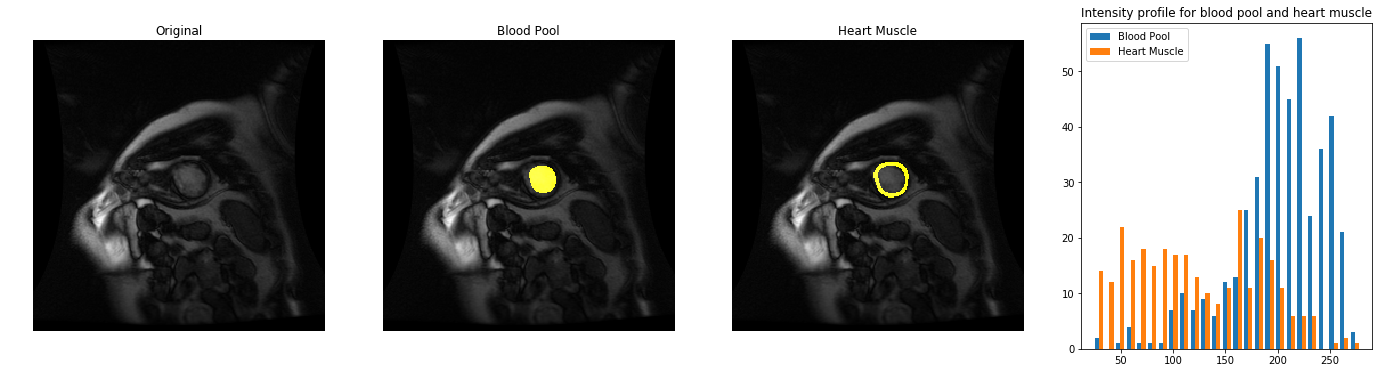

DICOM Image: data/dicoms/SCD0000301/40.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0040-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0040-ocontour-manual.txt


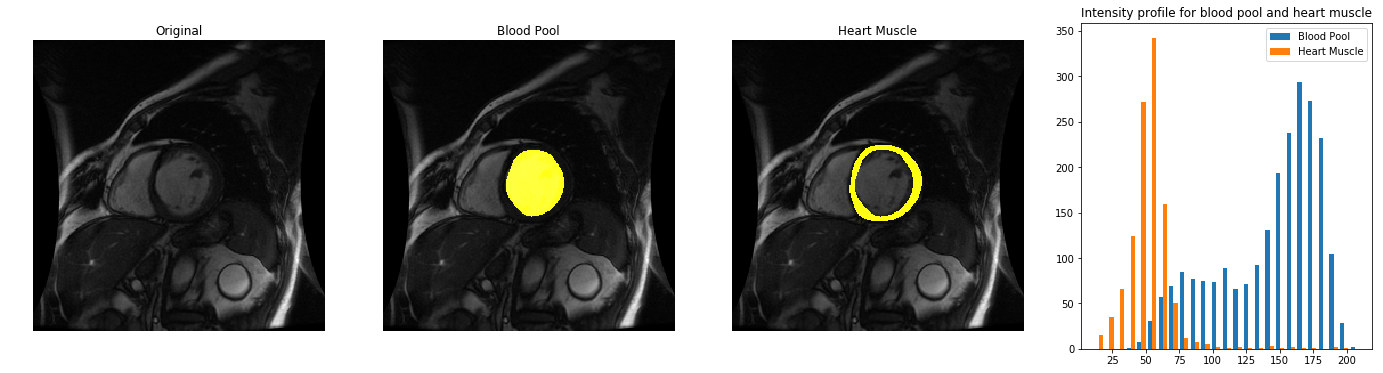

DICOM Image: data/dicoms/SCD0000301/80.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0080-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0080-ocontour-manual.txt


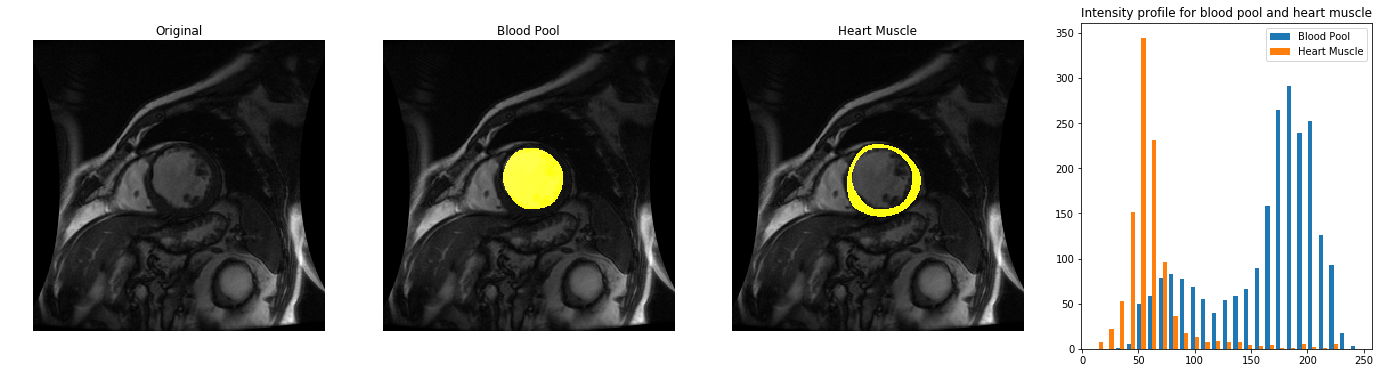

DICOM Image: data/dicoms/SCD0000301/100.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0100-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0100-ocontour-manual.txt


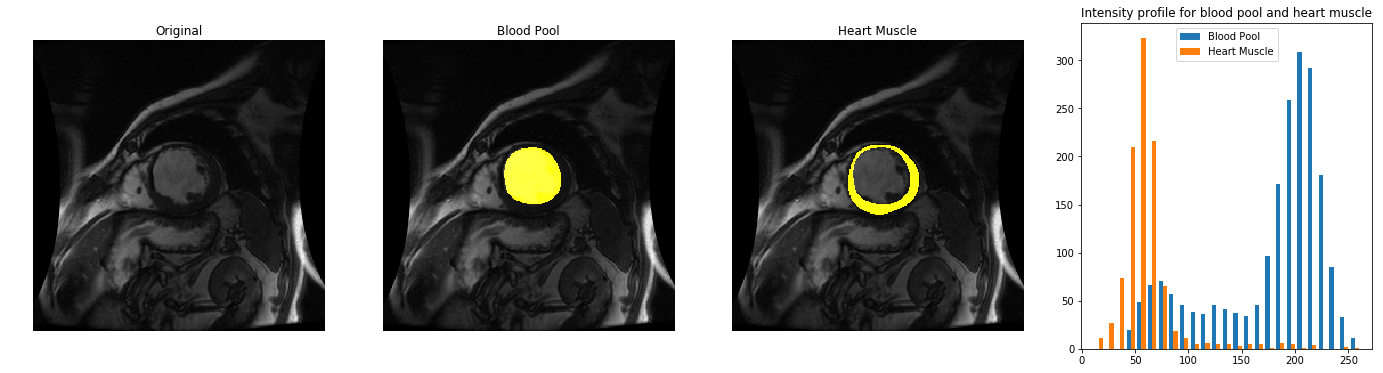

DICOM Image: data/dicoms/SCD0000301/120.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0120-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0120-ocontour-manual.txt


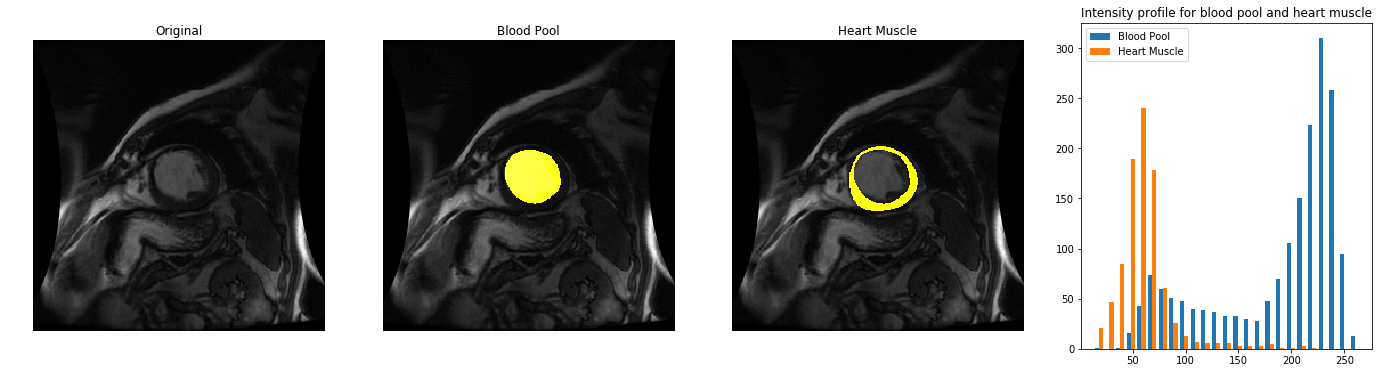

DICOM Image: data/dicoms/SCD0000301/140.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0140-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0140-ocontour-manual.txt


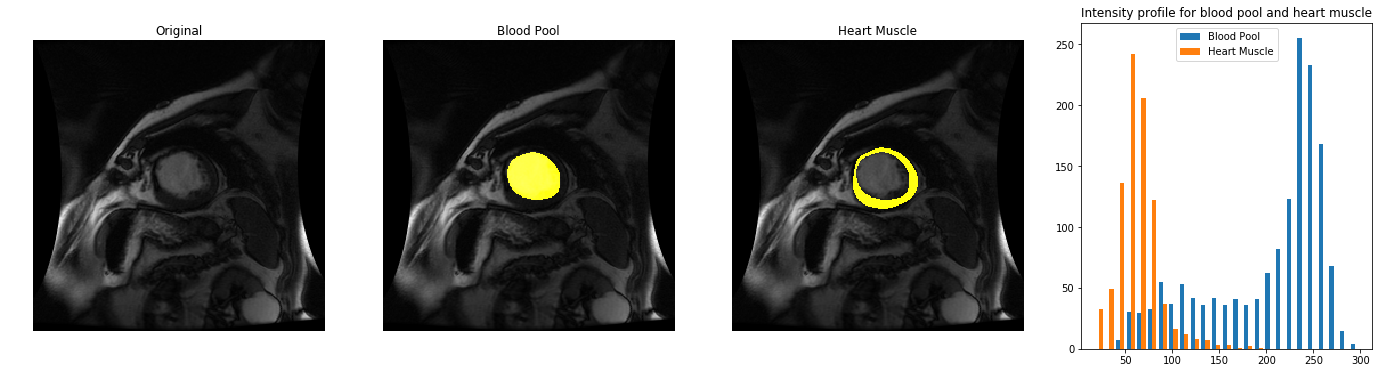

DICOM Image: data/dicoms/SCD0000301/20.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0020-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0020-ocontour-manual.txt


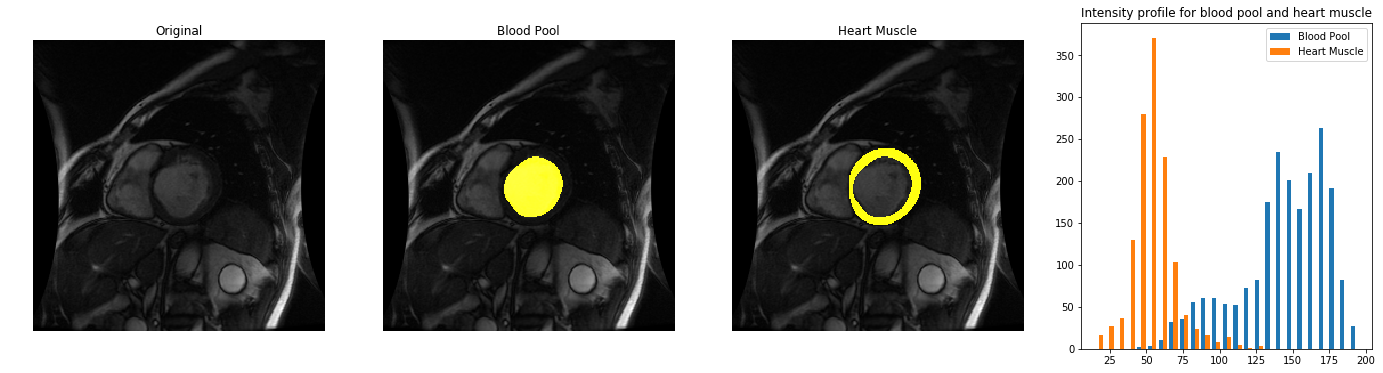

DICOM Image: data/dicoms/SCD0000301/60.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0060-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0060-ocontour-manual.txt


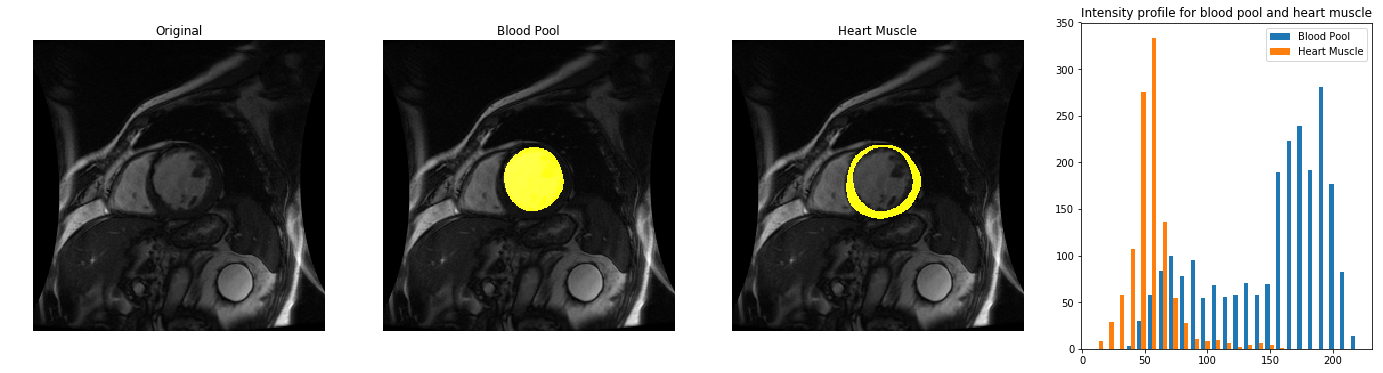

DICOM Image: data/dicoms/SCD0000301/180.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0180-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0180-ocontour-manual.txt


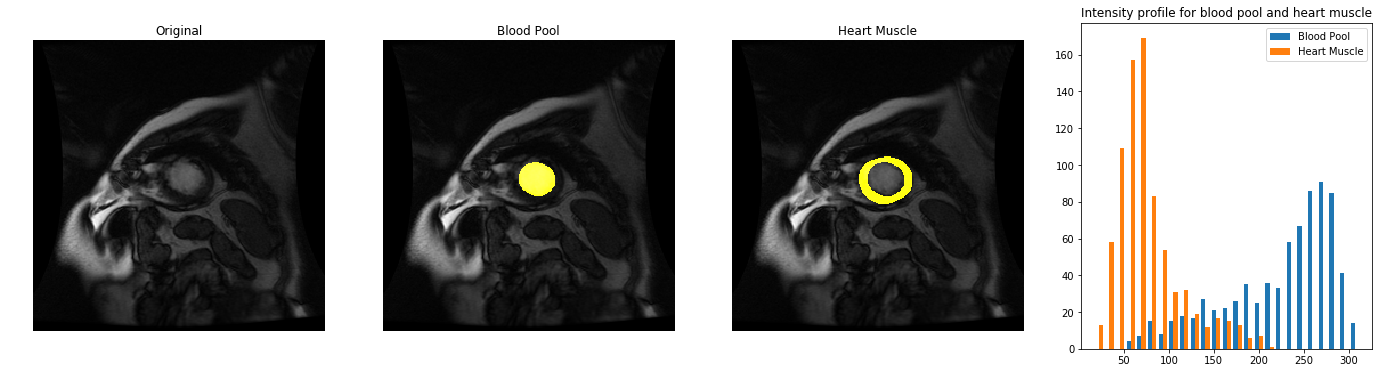

DICOM Image: data/dicoms/SCD0000301/160.dcm
i-contour mask file: data/contourfiles/SC-HF-I-4/i-contours/IM-0001-0160-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0160-ocontour-manual.txt


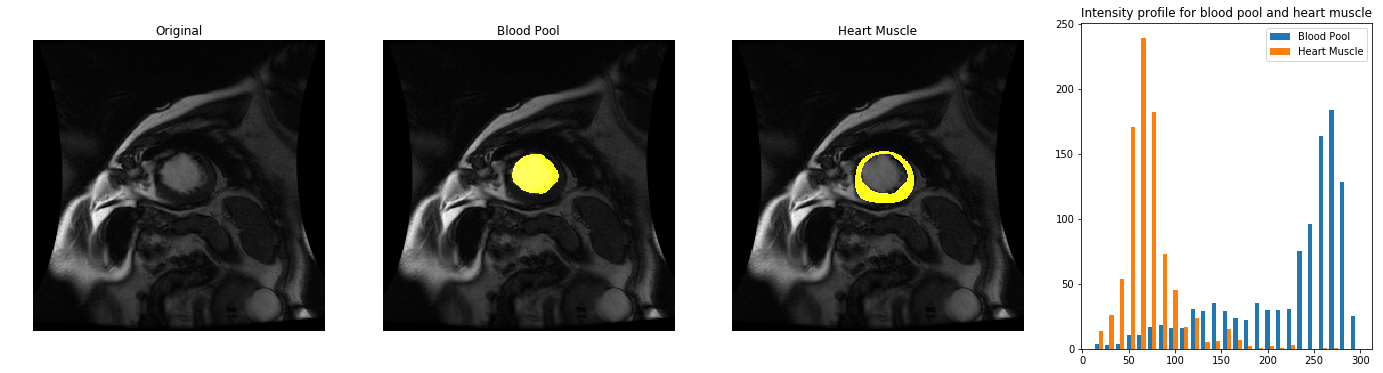

Patient ID: SCD0000401
DICOM Image: data/dicoms/SCD0000401/120.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0120-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0120-ocontour-manual.txt


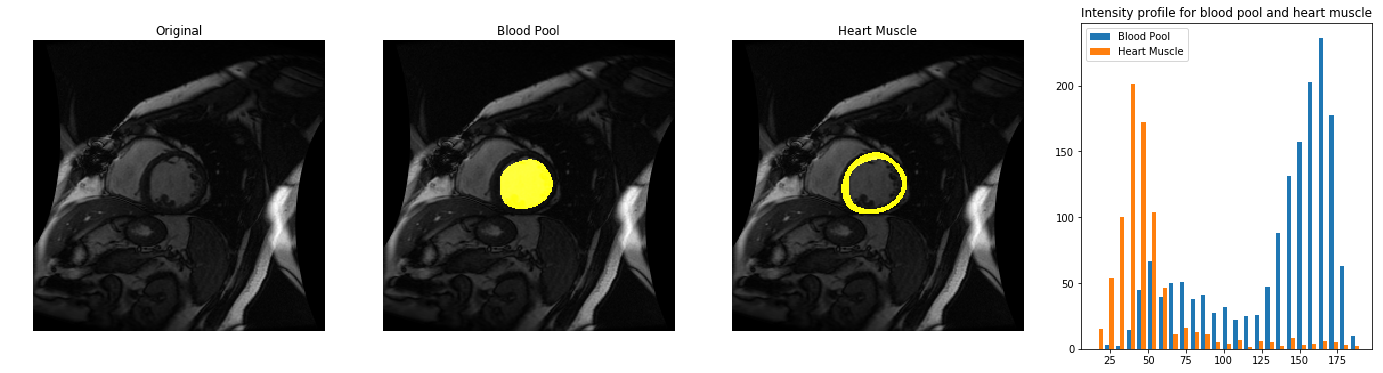

DICOM Image: data/dicoms/SCD0000401/40.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0040-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0040-ocontour-manual.txt


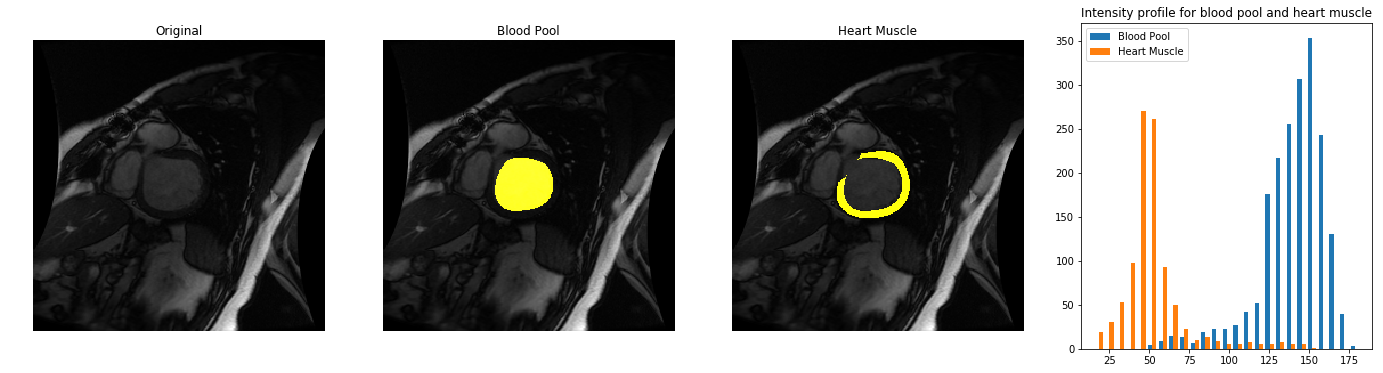

DICOM Image: data/dicoms/SCD0000401/80.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0080-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0080-ocontour-manual.txt


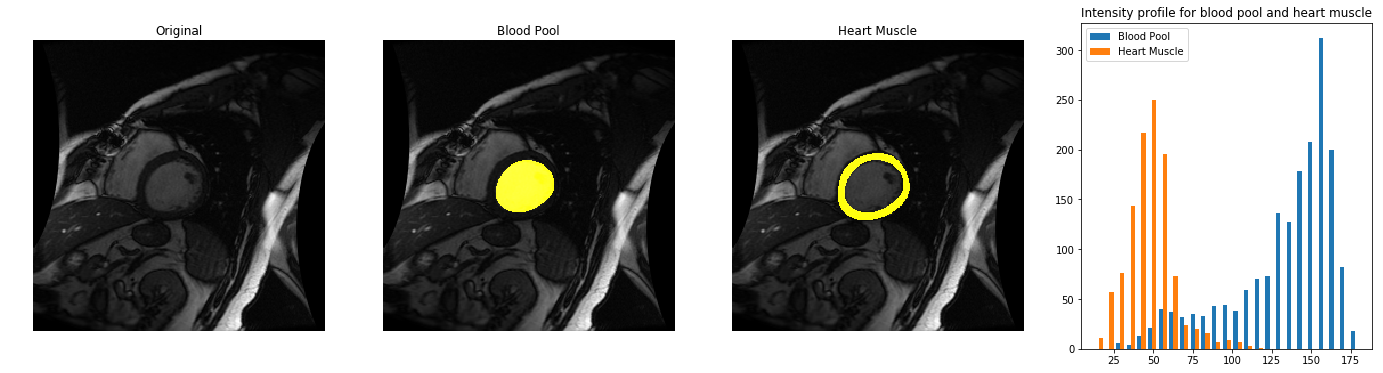

DICOM Image: data/dicoms/SCD0000401/100.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0100-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0100-ocontour-manual.txt


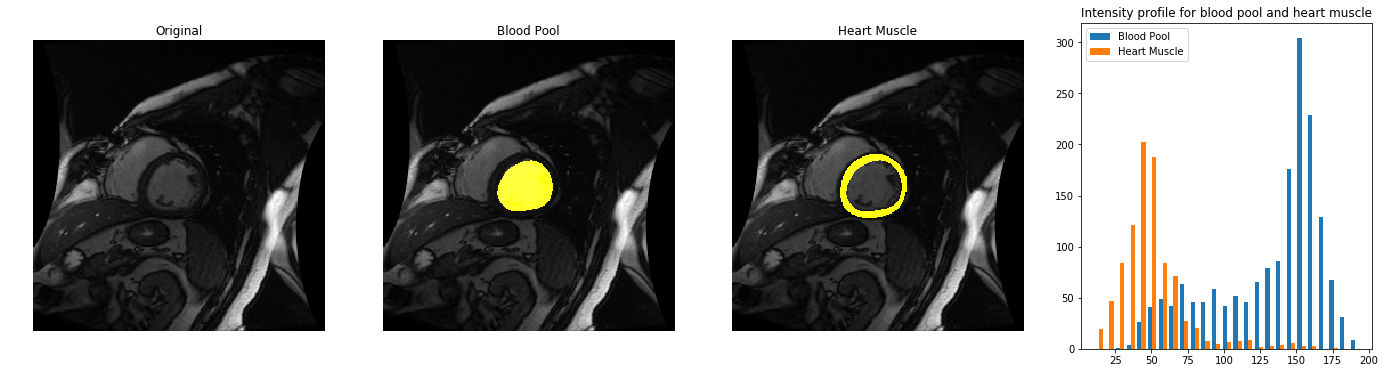

DICOM Image: data/dicoms/SCD0000401/200.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0200-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0200-ocontour-manual.txt


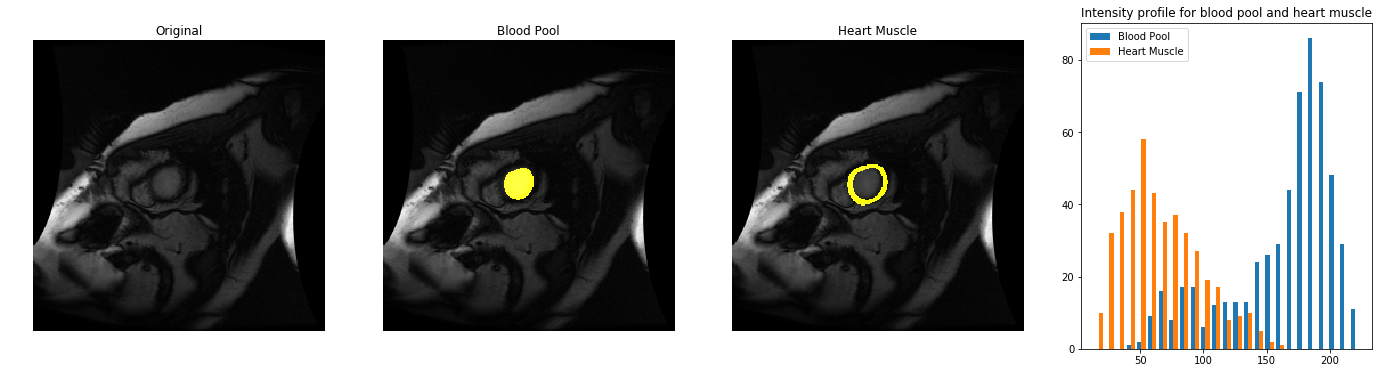

DICOM Image: data/dicoms/SCD0000401/140.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0140-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0140-ocontour-manual.txt


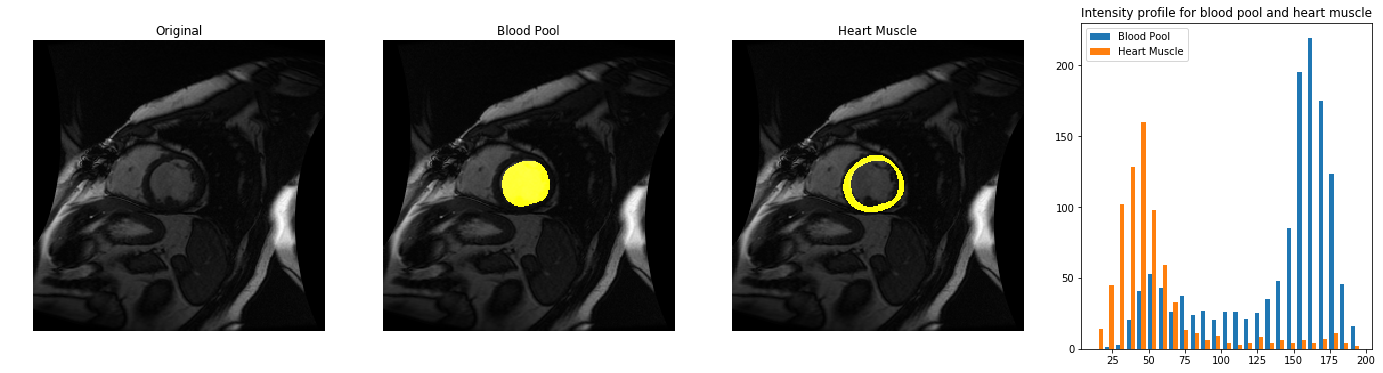

DICOM Image: data/dicoms/SCD0000401/60.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0060-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0060-ocontour-manual.txt


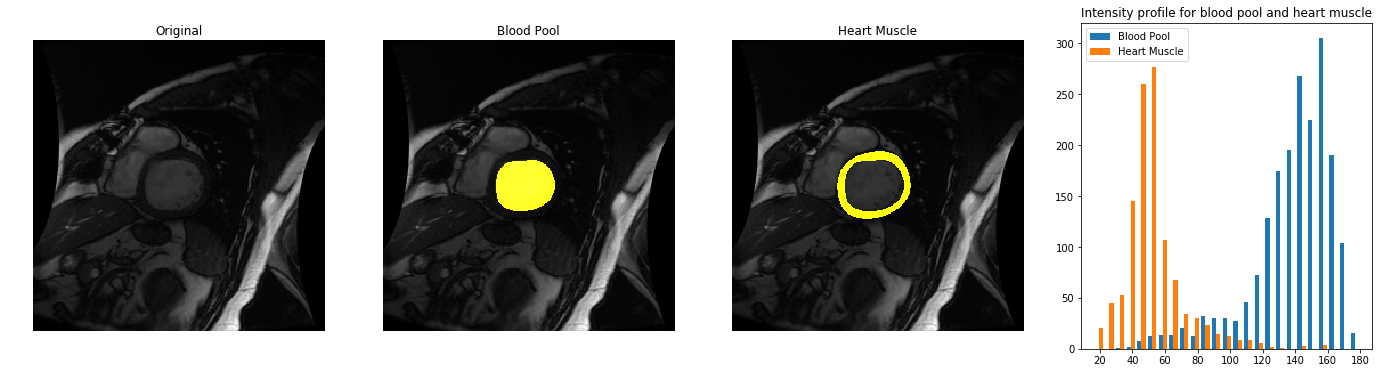

DICOM Image: data/dicoms/SCD0000401/180.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0180-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0180-ocontour-manual.txt


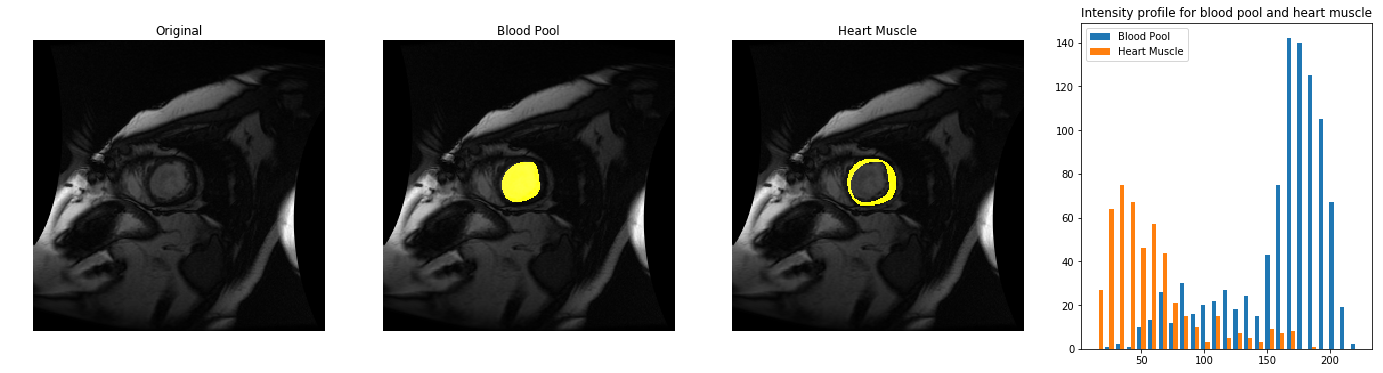

DICOM Image: data/dicoms/SCD0000401/160.dcm
i-contour mask file: data/contourfiles/SC-HF-I-5/i-contours/IM-0001-0160-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-5/o-contours/IM-0001-0160-ocontour-manual.txt


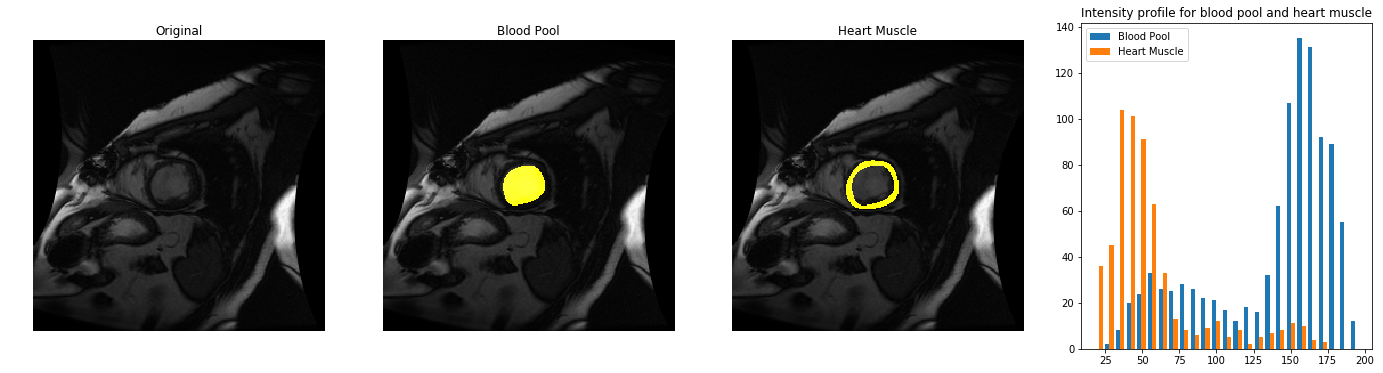

Patient ID: SCD0000501
DICOM Image: data/dicoms/SCD0000501/159.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0159-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0159-ocontour-manual.txt


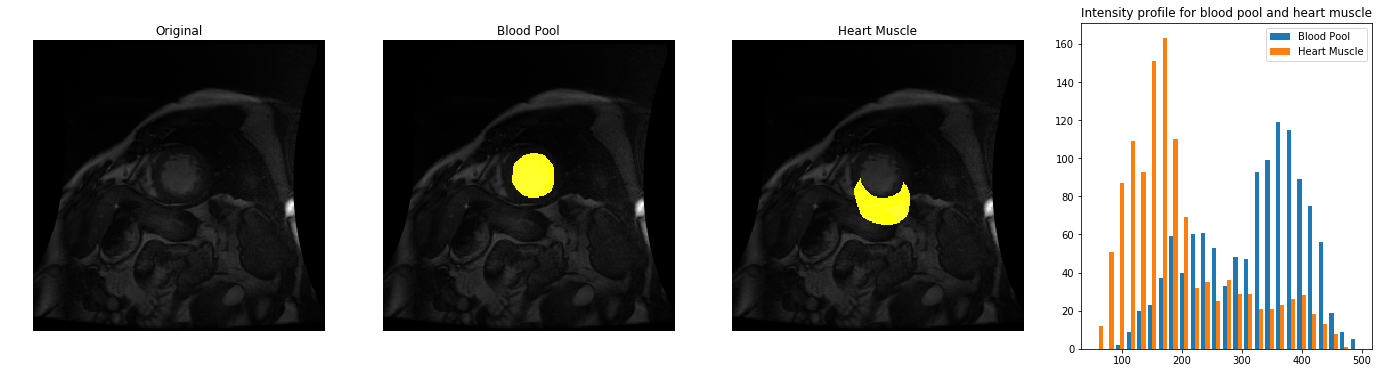

DICOM Image: data/dicoms/SCD0000501/99.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0099-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0099-ocontour-manual.txt


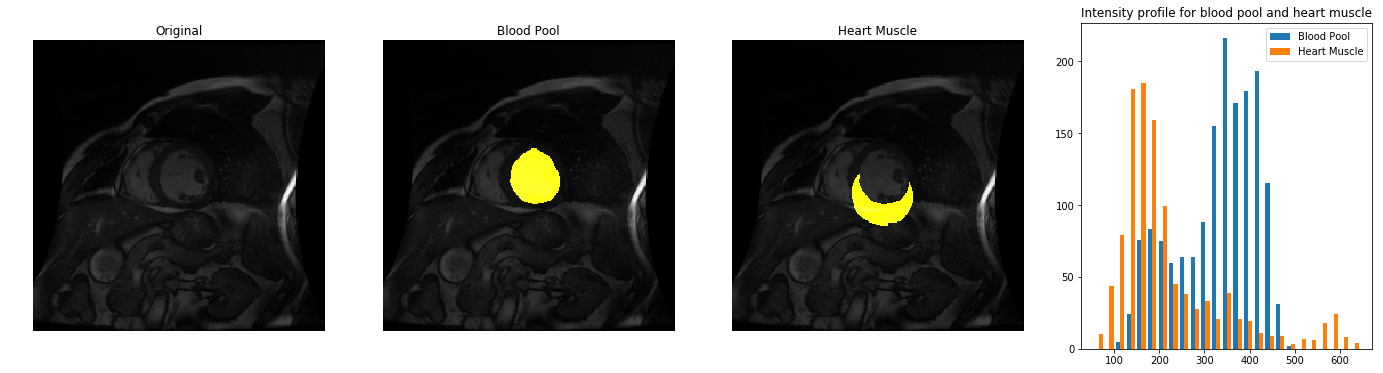

DICOM Image: data/dicoms/SCD0000501/119.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0119-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0119-ocontour-manual.txt


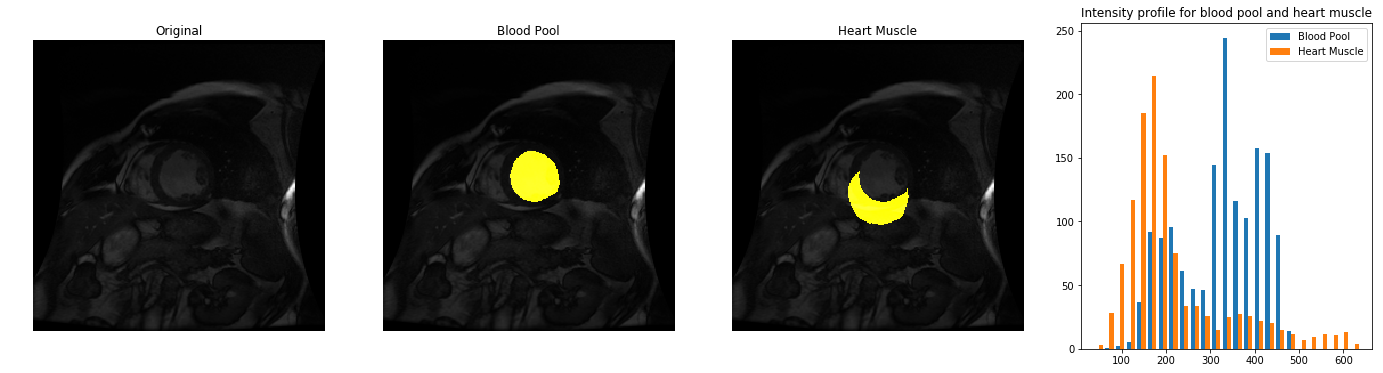

DICOM Image: data/dicoms/SCD0000501/139.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0139-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0139-ocontour-manual.txt


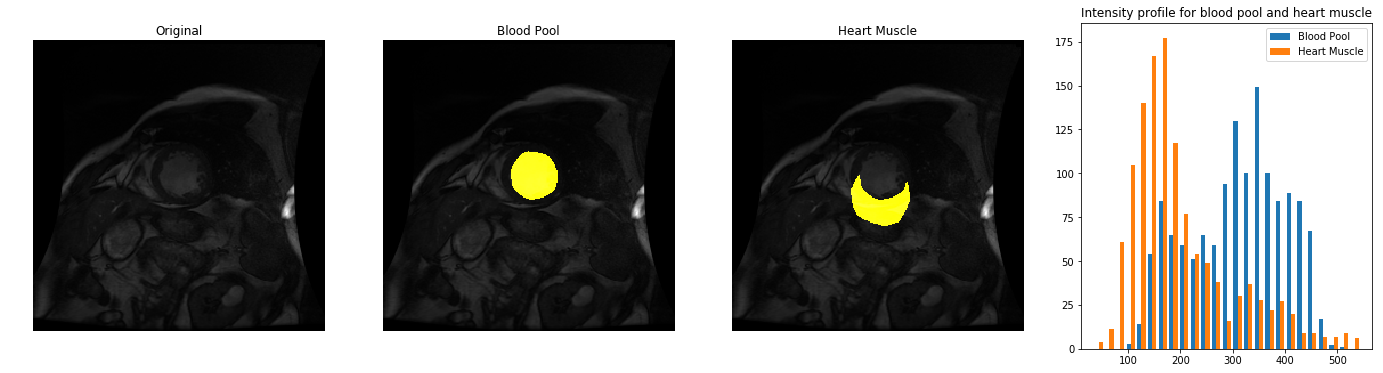

DICOM Image: data/dicoms/SCD0000501/219.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0219-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0219-ocontour-manual.txt


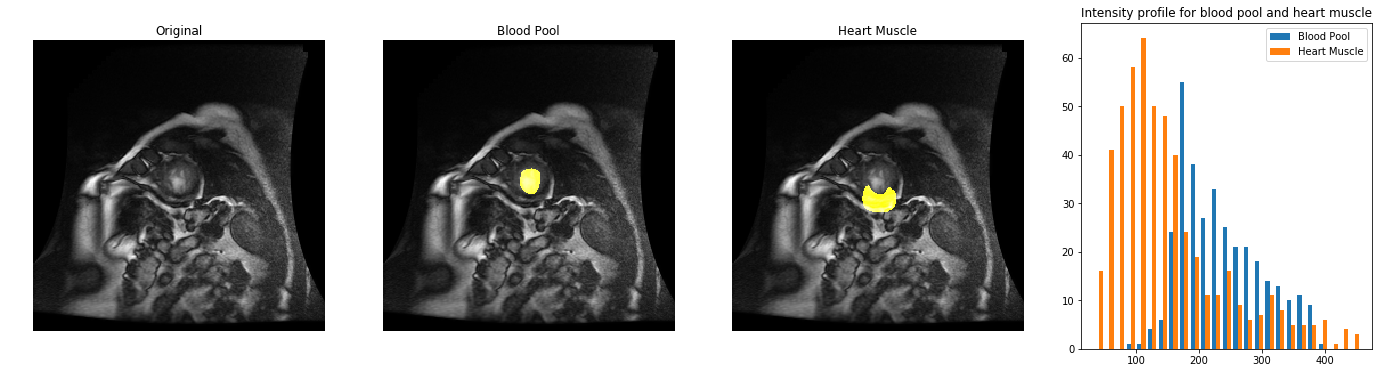

DICOM Image: data/dicoms/SCD0000501/179.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0179-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0179-ocontour-manual.txt


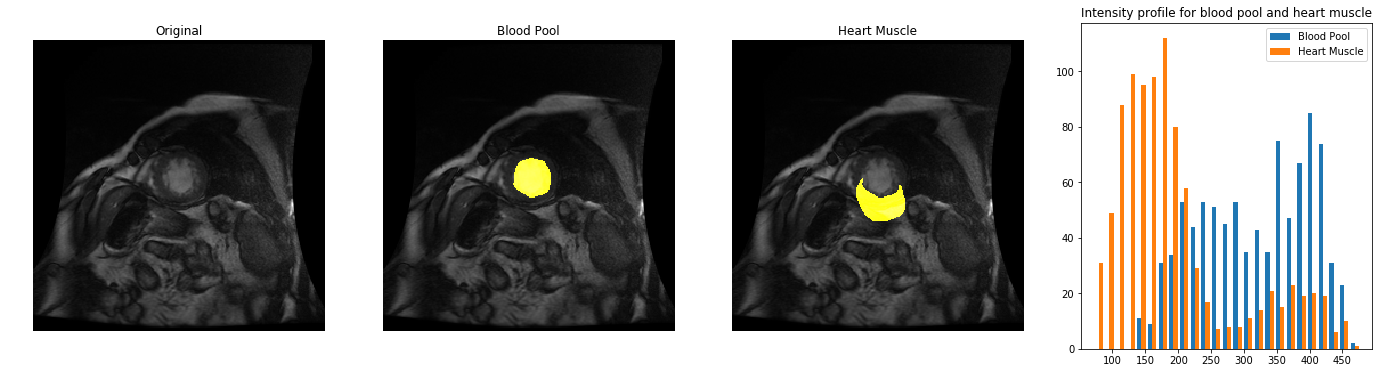

DICOM Image: data/dicoms/SCD0000501/199.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0199-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0199-ocontour-manual.txt


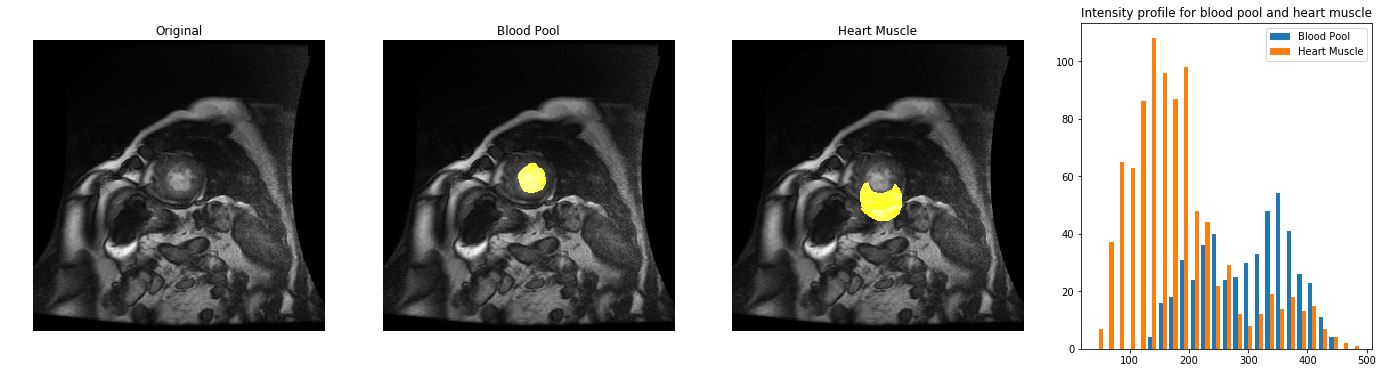

DICOM Image: data/dicoms/SCD0000501/59.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0059-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0059-ocontour-manual.txt


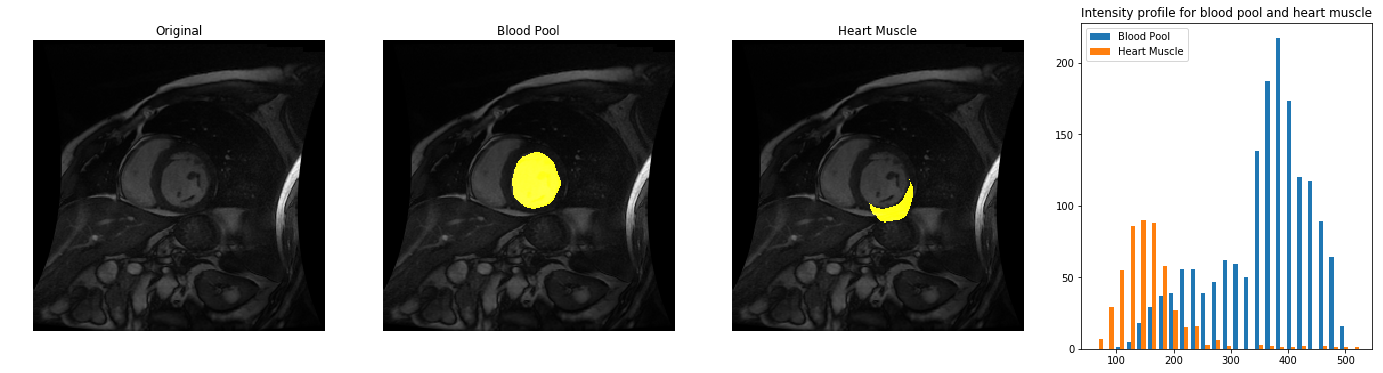

DICOM Image: data/dicoms/SCD0000501/79.dcm
i-contour mask file: data/contourfiles/SC-HF-I-6/i-contours/IM-0001-0079-icontour-manual.txt
o-contour mask file: data/contourfiles/SC-HF-I-6/o-contours/IM-0001-0079-ocontour-manual.txt


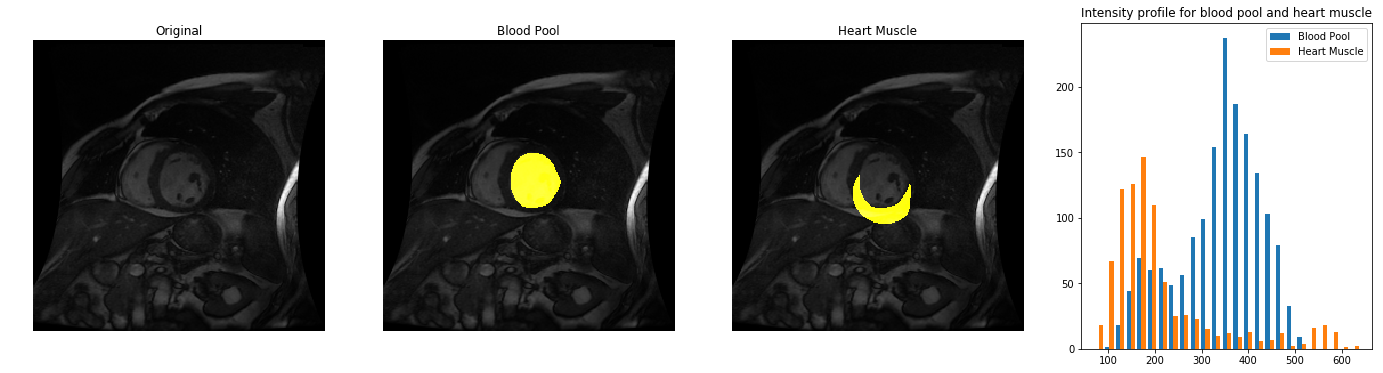

In [3]:
# Create patient IDs
patient_IDs = ['SCD0000{:d}01'.format(i) for i in range(1, 6)]

# For each patient ID...
for patient_id in patient_IDs:
    # Create DICOMLoader for this patient
    # Specify loading in o-contour data
    # and ensure we only load in this patient
    dl = DICOMLoader('data', load_ocontours=True, patient_IDs=[patient_id])
    
    # Set batch size to 1 as we want to see all data
    dl.batch_size = 1
    
    # Set seed so that order is reproducible
    dl.seed = 42
    
    # Get filenames too
    dl.return_filenames_with_batch = True
    
    # Go through the data now
    print("======\nPatient ID: {}\n======".format(patient_id))
    
    for (imgs, i_masks, o_masks, filenames) in dl:
        # Unpack
        img = imgs[0]
        i_mask = i_masks[0]
        o_mask = o_masks[0]
        
        print("DICOM Image: {}".format(filenames[0][0]))
        print("i-contour mask file: {}".format(filenames[0][1]))
        print("o-contour mask file: {}".format(filenames[0][2]))
        
        # Define the heart muscle mask
        # It is simply the o-contour mask with
        # the i-contour mask region set to False
        h_mask = o_mask.copy()
        h_mask[i_mask] = False
        
        # For display purposes
        # Show the i-contour mask region to be yellow
        i_img = np.dstack([img] * 3)
        i_img[...,0][i_mask] = np.max(img)
        i_img[...,1][i_mask] = np.max(img)
        
        # Do the same for the heart muscle mask
        h_img = np.dstack([img] * 3)
        h_img[...,0][h_mask] = np.max(img)
        h_img[...,1][h_mask] = np.max(img)
               
        # Convert to uint8 and scale to 255 for compatibility
        i_img = (i_img.astype(np.float) / np.max(img)) * 255
        i_img = i_img.astype(np.uint8)
        h_img = (h_img.astype(np.float) / np.max(img)) * 255
        h_img = h_img.astype(np.uint8)

        # Create a line of 4 plots that contain the
        # original image, the blood pool mask and
        # the region of the heart muscle
        f, ax = plt.subplots(1, 4, figsize=(24, 6))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original')
        ax[0].axis('off')
        
        ax[1].imshow(i_img)
        ax[1].set_title('Blood Pool')
        ax[1].axis('off')
        
        ax[2].imshow(h_img)
        ax[2].set_title('Heart Muscle')
        ax[2].axis('off')
        
        ax[3].hist([img[i_mask], img[h_mask]], bins=25)
        ax[3].set_title('Intensity profile for blood pool and heart muscle')
        ax[3].legend(('Blood Pool', 'Heart Muscle'))
        plt.show()

## Something to notice - Bimodal characteristics

Take note that the intensity profile had to be compressed to the range of $[0,255]$ so that the images could be displayed with Matplotlib.  However, we didn't need to do that for displaying the histogram of intensities for the blood pool and heart muscle regions.  By examining the intensity profiles of the blood pool and heart muscle for each patient and each pair of images separately, one can see that there is clearly a bimodal distribution of intensities shared between them.  This means that it's possible to choose an intensity value that could separate between blood pool intensities and the heart muscle intensities but do notice that there is no clear threshold that would be able to separate between the two.  However, a good heuristic to try would be using the method by [Nobuyuki Otsu](https://en.wikipedia.org/wiki/Nobuyuki_Otsu) and is aptly named [Otsu's Method](https://en.wikipedia.org/wiki/Otsu%27s_method).  Given the histogram or a distribution of intensities for the image and if the characteristics of the distribution are bimodal meaning that there are two "classes" of objects or entities in the image, the method exhaustively searches for the threshold that minimizes the intra-class variance (the variance within each class) and is defined as a weighted sum of variances of the two classes:

$$
\sigma_w^{2}(t) = \omega_0(t) \sigma_0^{2}(t) + \omega_1(t) \sigma_1^{2}(t)
$$

The weights $\omega_0(t)$ and $\omega_1(t)$ are the probabilities of the two classes separated by the threshold $t$ and $\sigma_0^{2}(t)$ and $\sigma_1^{2}(t)$ are the variances of the two classes for the said threshold.  Finally, $\sigma_w^{2}(t)$ is the intra-class variance defined for the threshold $t$.

What is required first is to transform the histogram of intensities into a probability distribution.  Assuming that all intensties are equally likely to be encountered, we can transform the histogram into a probability distribution $p(i)$ with $i$ being an intensity by simply taking each entry in the histogram and dividing by the total number of entries.  The weight $\omega_0(t)$ is therefore computed by the total sum of probabilities from $0$ up to but not including the threshold $t$.  The weight $\omega_1(t)$ is simply the remainder of the sum:

$$
\omega_0(t) = \sum_{i=0}^{t - 1} p(i)
$$

$$
\omega_1(t) = \sum_{i=t}^{L - 1} p(i)
$$

$L$ is the total number of bins in the histogram.  Otsu demonstrates that minimizing the intra-class variance is equivalent to maximizing the inter-class variance (the variance between the two classes).  Given a threshold $t$, the inter-class variance becomes [1]:

$$
\sigma_b^{2}(t) = \omega_0(t)\omega_1(t)[\mu_0(t) - \mu_1(t)]^{2}
$$

In a similar fashion, the class means $\mu_0(t)$ and $\mu_1(t)$ defined for the threshold $t$ become:

$$
\mu_0 = \frac{\sum_{i=0}^{t-1}ip(i)}{\omega_0(t)}
$$

$$
\mu_1 = \frac{\sum_{i=t}^{L-1}ip(i)}{\omega_1(t)}
$$

Knowing the above, the algorithm is to simply iterate over all possible intensities and determine the intensity that maximizes $\sigma_b^{2}(t)$ which is thus the desired threshold used to separate between the two classes.  Also note that there is a recurrence relation for the computed values above up to the potential threshold $t$ so one can simply use information from a previously known value $t'$ to help compute the value at $t$.

More explicitly:

1. Compute the histograms and probabilities for each intensity in the image
2. Compute the initial weights and means $\omega_i(0), \mu_i(0),~\text{for } i = 0, 1$
3. For each threshold $t = 1, 2, \ldots, L - 1$
    - Update $\omega_i$ and $\mu_i,~\text{for } i = 0, 1$
    - Compute $\sigma_b^{2}(t)$
4. Determine the intensity threshold that corresponds to the largest $\sigma_b^{2}(t)$

## Proposed Approach - Using Otsu's algorithm

Using the above knowledge, one proposed heuristic method is to segment out the area in question for each DICOM image using the *o-contour*.  We can then apply Otsu's algorithm to the segmented area and threshold the result.  Once can notice that the intensities of the heart muscle are on the left or lower side of the intensity profile and the blood pool intensities are on the right side of the intensity profile.  Therefore once we determine the correct threshold with Otsu's algorithm, we can find the predicted mask defined by the *i-contour* by thresholding the intensities defined within the *o-contour* above this threshold.

To determine the validity of the approach, we can compute the [Intersection over Union (IoU) or the Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) between the predicted mask computed from Otsu's algorithm and the ground truth *i-contour* mask.  It is a normalized score between $[0,1]$ where higher scores denote higher similarity between two entities and thus the predicted mask more agrees with the ground truth.  To make the analysis more palatable, we will compute the mean IoU score for each patient individually as each patient has different characteristics and we wouldn't want the characteristics of other patients interfering with each other.

To save time we will be using an already provided implementation of Otsu's algorithm through scikit-image.  However, that implementation requires the image intensities be normalized between $[0,1]$ so for each image, we simply divide by the largest intensity seen and we enforce the number of bins in the histogram to be 256 (the default for scikit-image).

As a means of illustration, we will save the first image, predicted *i-contour* mask and ground truth *i-contour* mask for each patient and display them to have some grasp as to how we're doing heuristically.

Patient ID: SCD0000101


Mean of IoUs: 0.7606467772984542
Standard Deviation of IoUs: 0.1161757287205924

Patient ID: SCD0000201


Mean of IoUs: 0.7588970956158727
Standard Deviation of IoUs: 0.1295355265867874

Patient ID: SCD0000301


Mean of IoUs: 0.7631015896140152
Standard Deviation of IoUs: 0.03674686080350901

Patient ID: SCD0000401


Mean of IoUs: 0.7964240503457963
Standard Deviation of IoUs: 0.07058088624228724

Patient ID: SCD0000501


Mean of IoUs: 0.4207713868589195
Standard Deviation of IoUs: 0.13055824683850348

Patient ID: SCD0000101



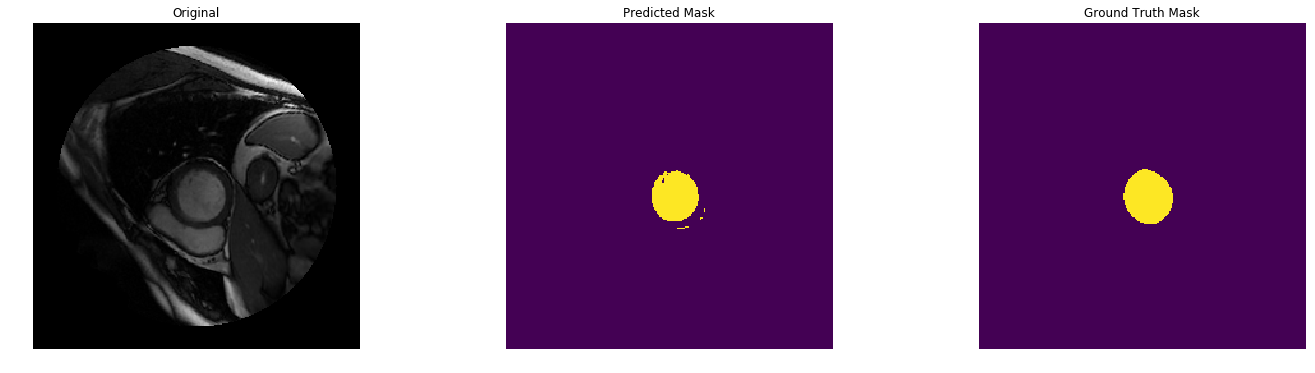

Patient ID: SCD0000201



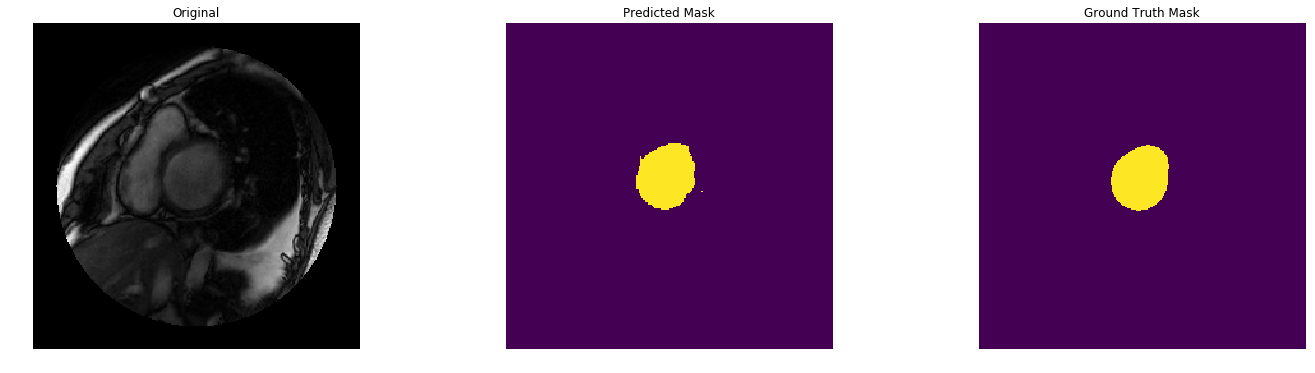

Patient ID: SCD0000301



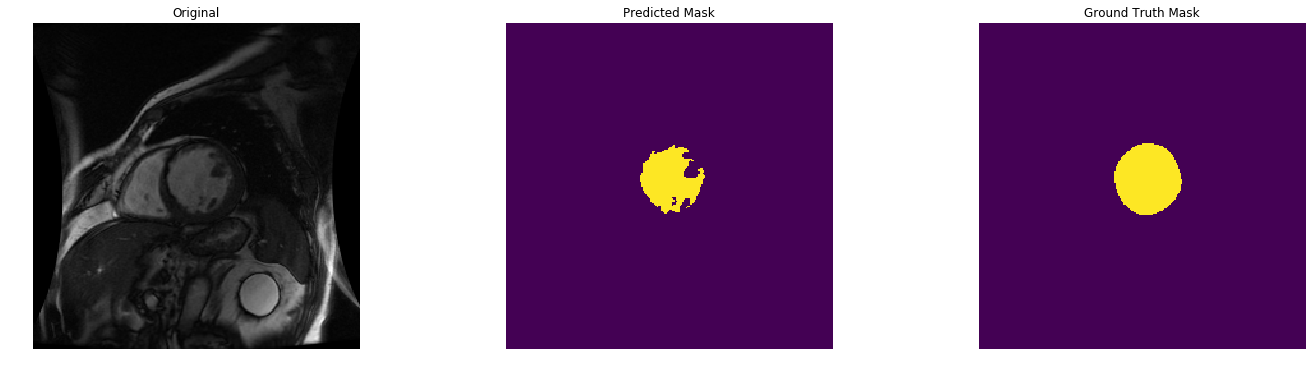

Patient ID: SCD0000401



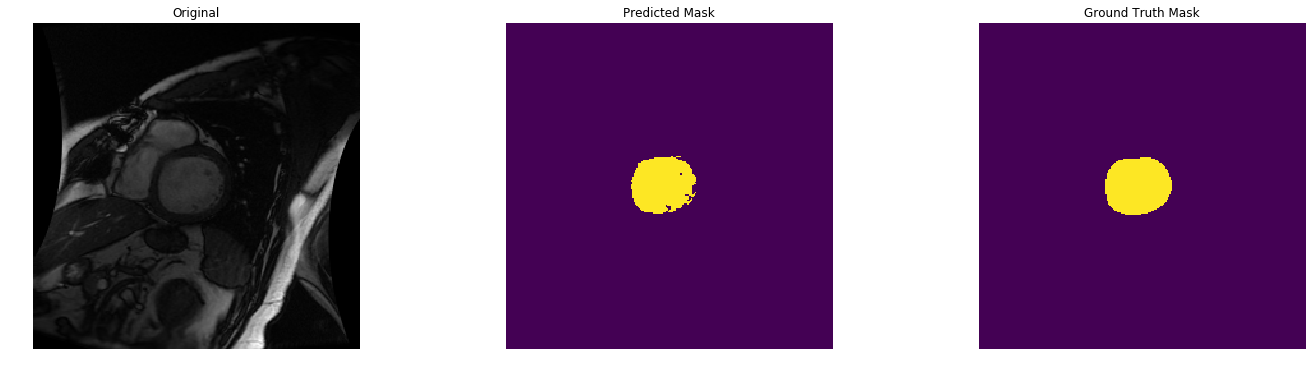

Patient ID: SCD0000501



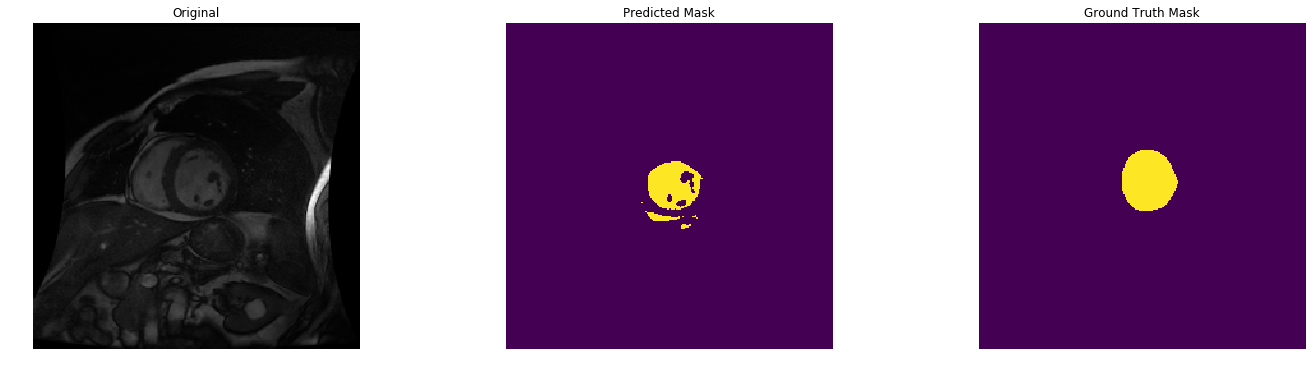

In [3]:
# To compute the IoU between two masks
compute_iou = lambda x, y: np.logical_and(x, y).sum() / np.logical_or(x, y).sum()

# Remembers the first results of each patient
first_results = []

# Stores the mean IoUs for each patient
mean_ious = []

# For each patient ID...
for patient_id in patient_IDs:
    # Create DICOMLoader for this patient
    # Specify loading in o-contour data
    # and ensure we only load in this patient
    dl = DICOMLoader('data', load_ocontours=True, patient_IDs=[patient_id])
    
    # Set batch size to 1 as we want to see all data
    dl.batch_size = 1
    
    # Set seed so that order is reproducible
    dl.seed = 42
    
    # Get filenames too
    dl.return_filenames_with_batch = True
    
    # Stores the IoUs per patient
    ious = [[None, None]] * len(dl)
    img_to_save = None
    pred_mask_to_save = None
    gt_mask = None
    
    print("======\nPatient ID: {}\n======".format(patient_id))
    
    for i, (imgs, i_masks, o_masks, filenames) in enumerate(dl):
        # Unpack
        img = imgs[0]
        i_mask = i_masks[0]
        o_mask = o_masks[0]

        # Convert to [0,1] for compatibility
        img = (img.astype(np.float) / np.max(img))
        
        # Compute Otsu threshold - only operate on the pixels within
        # the o-contour mask
        thresh = threshold_otsu(img[o_mask])
        
        # Compute predicted mask
        pred_mask = img >= thresh
        
        # Remove unwanted information
        # Any areas that are outside of the o-contour mask are
        # not important so set those to False
        pred_mask[~o_mask] = False
        
        # Compute IoU
        ious[i] = [filenames[0][0], compute_iou(i_mask, pred_mask)]
        
        # Remember the first set of data for the patient
        if img_to_save is None and pred_mask_to_save is None and gt_mask is None:
            img_to_save = (255*img).astype(np.uint8)
            pred_mask_to_save = pred_mask.astype(np.float)
            gt_mask = i_mask.astype(np.float)
    
    # Extract out just the values
    iou_vals = [v[1] for v in ious]
    
    # Display a table of DICOM image and IoU score
    display(HTML(tabulate.tabulate(ious, tablefmt='html')))
    
    # Add to the list of displaying
    first_results.append((img_to_save, pred_mask_to_save, gt_mask))
    
    # Display mean and standard deviation
    mean_ious.append(np.mean(iou_vals))
    print("Mean of IoUs: {}".format(mean_ious[-1]))
    print("Standard Deviation of IoUs: {}\n".format(np.std(iou_vals)))

# Display the first of each result
for name, (img, pred_mask, gt_mask) in zip(patient_IDs, first_results):
    print("======\nPatient ID: {}\n======\n".format(name))
    f, ax = plt.subplots(1, 3,figsize=(24, 6))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(pred_mask)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    ax[2].imshow(gt_mask)
    ax[2].set_title('Ground Truth Mask')
    ax[2].axis('off')
    plt.show()

The method as is produces passable predicted masks with an average IoU score between 0.75 to 0.79 for each patient with the exception of the patient ID SCD0000501, corresponding to the masks where the *i-contour* and *o-contour* data does not seem to align. 

## Further Extensions

With the above method, there are two things we can do to improve the quality of the masks beyond the original Otsu algorithm.  The fact that we visually displayed a sample of each predicted mask per patient is important to get these points across.

1. For some of the predicted masks, there are small isolated islands of noise that can be eliminated that will slightly drive the score higher.  If you look at any ground truth mask, it is all one consolidated blob.
2. There are holes in the predicted mask that can be filled in that will also drive the score slightly higher.

Putting these ideas into practice is quite straight forward.  To mitigate issue #1, we can perform a connected components analysis by labelling all isolated blobs with a unique ID number.  After, we can find the total area or total number of pixels taken up by each isolated blob and only allow the blob with the largest area to remain.  This blob will most likely contain the majority of the pixels that belong to the blood pool.  To mitigate issue #2, one can simply perform hole filling of the mask.  The process to fill in holes is to use the origin or the top left corner of the image as a seed pixel and one performs a flood fill turning all pixels that are `False` to `True`.  The resulting output would be the regions that have holes to be marked as `False` so we simply invert this result to have values that are holes set to `True` and we set these regions in the mask to `True` [2].

Fortunately in the SciPy package, there is an algorithm already in place to allow us to do this.  Let's redo the same logic as previously but with these two additional steps implemented.


Patient ID: SCD0000101


Mean of IoUs: 0.7645017829335481
Standard Deviation of IoUs: 0.11865952030805134

Patient ID: SCD0000201


Mean of IoUs: 0.7618971575241702
Standard Deviation of IoUs: 0.13192761867767475

Patient ID: SCD0000301


Mean of IoUs: 0.7692805339631097
Standard Deviation of IoUs: 0.04221808676619855

Patient ID: SCD0000401


Mean of IoUs: 0.8083556727961114
Standard Deviation of IoUs: 0.07291133465248006

Patient ID: SCD0000501


Mean of IoUs: 0.47326323516565894
Standard Deviation of IoUs: 0.19884974629853422

Patient ID: SCD0000101



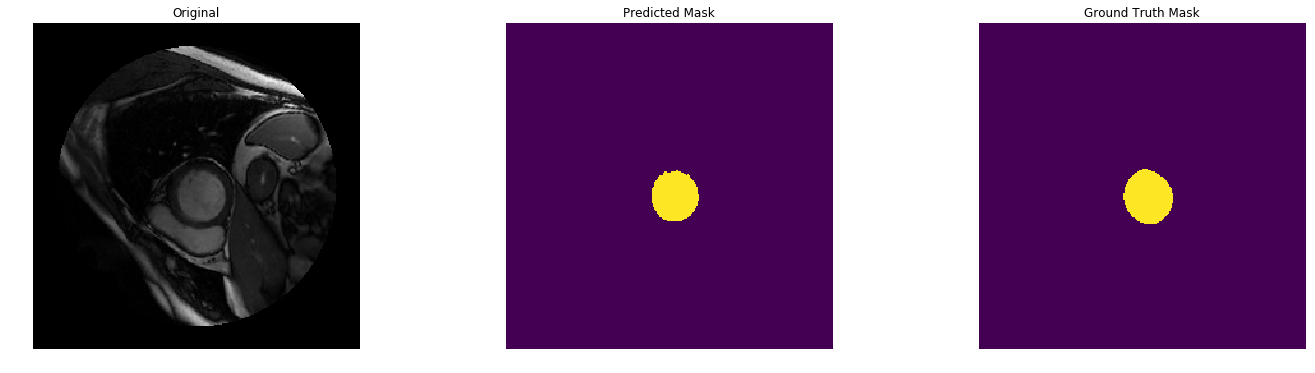

Patient ID: SCD0000201



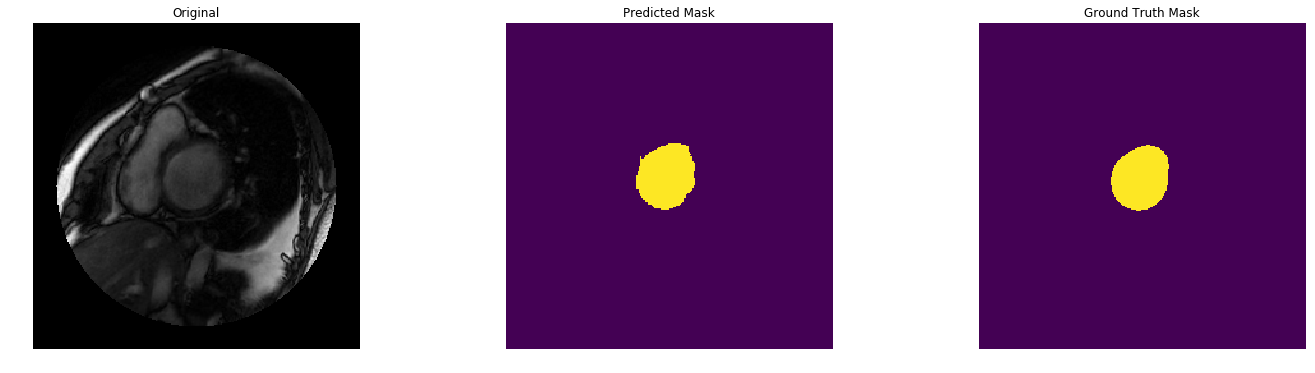

Patient ID: SCD0000301



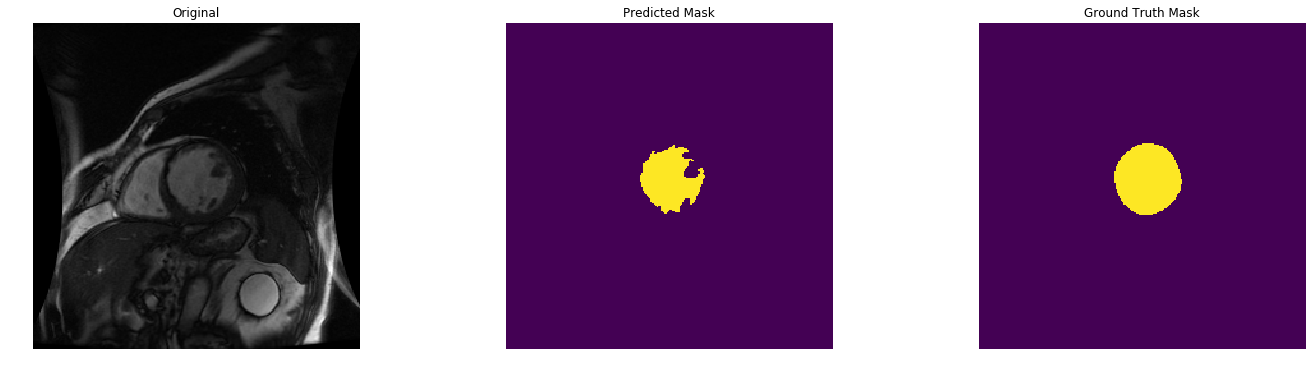

Patient ID: SCD0000401



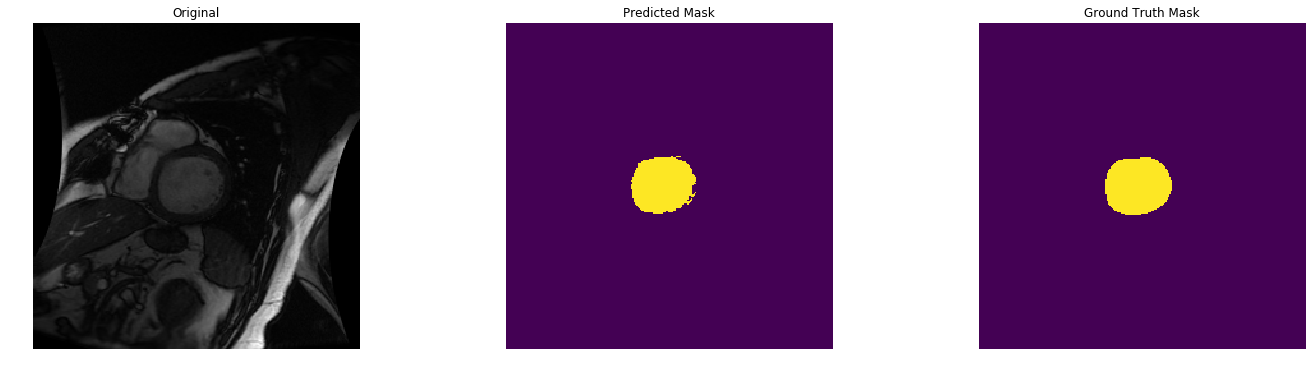

Patient ID: SCD0000501



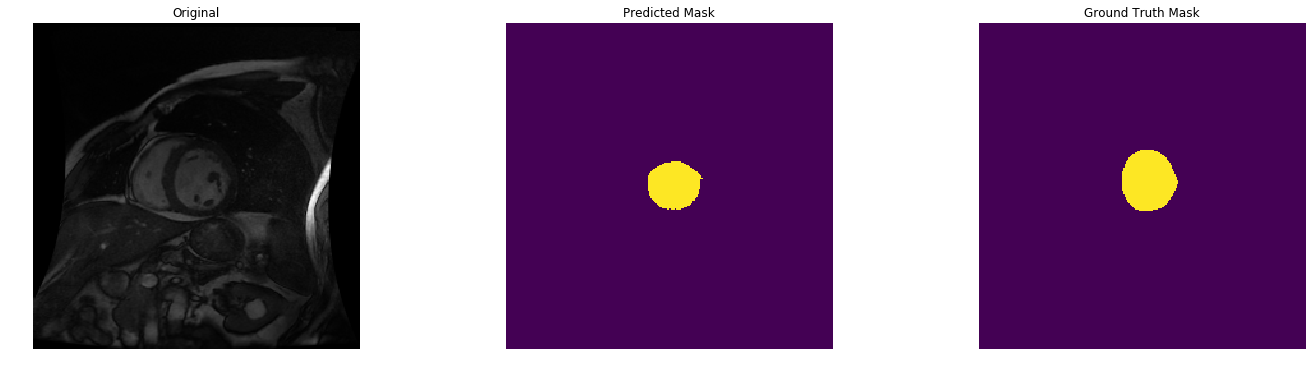

In [4]:
# Remembers the first results of each patient
first_results = []

# Stores the mean IoUs for the improved algorithm
mean_ious_new = []

# For each patient ID...
for patient_id in patient_IDs:
    # Create DICOMLoader for this patient
    # Specify loading in o-contour data
    # and ensure we only load in this patient
    dl = DICOMLoader('data', load_ocontours=True, patient_IDs=[patient_id])
    
    # Set batch size to 1 as we want to see all data
    dl.batch_size = 1
    
    # Set seed so that order is reproducible
    dl.seed = 42
    
    # Get filenames too
    dl.return_filenames_with_batch = True
    
    # Stores the IoUs per patient
    ious = [[None, None]] * len(dl)
    img_to_save = None
    pred_mask_to_save = None
    gt_mask = None
    
    print("======\nPatient ID: {}\n======".format(patient_id))
    
    for i, (imgs, i_masks, o_masks, filenames) in enumerate(dl):
        # Unpack
        img = imgs[0]
        i_mask = i_masks[0]
        o_mask = o_masks[0]
        
        # Convert to [0,1] for compatibility
        img = (img.astype(np.float) / np.max(img))
        
        # Compute Otsu threshold - only operate on the pixels within
        # the o-contour mask
        thresh = threshold_otsu(img[o_mask])
        
        # Compute predicted mask
        pred_mask = img >= thresh
        
        # Remove unwanted information
        # Any areas that are outside of the o-contour mask are
        # not important so set those to False
        pred_mask[~o_mask] = False
        
        ### Issue #1 - Isolate out the largest blob
        # Do connected components analysis
        # The required input is an integer type image so simply
        # convert all values from False/True to 0/255 and
        # convert the type
        lbl_img = label((255*(pred_mask.astype(np.uint8))))
        
        # Find the properties of each blob
        props = regionprops(lbl_img)
        
        # Isolate out the areas of each blob
        areas = [p.filled_area for p in props]
        lbls = [p.label for p in props] # Also get the labels
        
        # Extract out the largest area and associated label
        ind = np.argmax(areas)
        max_lbl = lbls[ind]
        
        # Get the mask now that is associated with this label
        pred_mask = lbl_img == max_lbl
        
        ### Issue #2 - Fill in the holes
        pred_mask = binary_fill_holes(pred_mask)
        
        # Compute IoU
        ious[i] = [filenames[0][0], compute_iou(i_mask, pred_mask)]
        
        # Retain the first image of each patient for display
        if img_to_save is None and pred_mask_to_save is None and gt_mask is None:
            img_to_save = (255*img).astype(np.uint8)
            pred_mask_to_save = pred_mask.astype(np.float)
            gt_mask = i_mask.astype(np.float)
    
    # Extract out just the values
    iou_vals_new = [v[1] for v in ious]
    
    # Display a table of DICOM image and IoU score
    display(HTML(tabulate.tabulate(ious, tablefmt='html')))
    
    # Add to the list of displaying
    first_results.append((img_to_save, pred_mask_to_save, gt_mask))
    
    # Display mean and standard deviation
    mean_ious_new.append(np.mean(iou_vals_new))
    print("Mean of IoUs: {}".format(mean_ious_new[-1]))
    print("Standard Deviation of IoUs: {}\n".format(np.std(iou_vals_new)))

# Display the first of each result
for name, (img, pred_mask, gt_mask) in zip(patient_IDs, first_results):
    print("======\nPatient ID: {}\n======\n".format(name))
    f, ax = plt.subplots(1, 3,figsize=(24, 6))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(pred_mask)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    ax[2].imshow(gt_mask)
    ax[2].set_title('Ground Truth Mask')
    ax[2].axis('off')
    plt.show()

Let's compare the average IoU of the original and modified implementation and see how much things have improved.  The first column displays the patient ID, the second column displays the mean IoU scores of each patient through the original Otsu method and the last column shows the scores for the improved method.

In [5]:
final_ious = [(f, a, b) for (f, a, b) in zip(patient_IDs, mean_ious, mean_ious_new)]
display(HTML(tabulate.tabulate(final_ious, tablefmt='html')))

With the two issues resolved, the IoU scores have certainly increased - especially the last set where the increase is more significant than the other patients even though the *i-contour* and *o-contour* data do not align.

## Another possible implementation - Using Morphology combined with Otsu

With the above threshold based approach, even with the modified implementation using blob analysis and hole filling, the spatial coherence of pixels is not being used and can certainly lend towards a more intelligent algorithm.  By leveraging the observation that the intensity profiles of the heart muscles and blood pool are bimodal and occupy separate areas of the intensity profiles for an image, one can iteratively perform [morphological erosion](https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm) by incrementally reducing the total area of the mask, starting from the outer mask and with a small kernel, like a 3 x 3 square structure element or kernel.  At each iteration, we examine the intensities of the perimeter of the outer mask which can be extracted by performing erosion with the said kernel and performing a bitwise XOR.  Regions that are external and internal to the contour would be set to `False` while only the perimeter extracted after erosion would remain.

The heart muscle region has one mode of distribution of intensities so if we examined for example the mean intensity, continually eroding the mask and examining the perimeter of the intensities should share the same mean intensity until the blood pool region is encountered.  We stop when there is nothing left to erode, or when the outer mask is completely empty.  As soon as we enter the region inside the blood pool, the mean intensity should change as this has another mode of distribution of intensities.  By providing this array of intensities into the Otsu algorithm, we should be able to isolate out the mean intensity required for a good separation between the heart muscle and blood pool regions and thus find the corresponding mask that provided this best mean intensity.

We'll again use the same code as we had before but we would implement this approach instead.

Patient ID: SCD0000101


Mean of IoUs: 0.8331031729869327
Standard Deviation of IoUs: 0.06487403349684628

Patient ID: SCD0000201


Mean of IoUs: 0.803360184057398
Standard Deviation of IoUs: 0.16104372738865416

Patient ID: SCD0000301


Mean of IoUs: 0.8358522528727365
Standard Deviation of IoUs: 0.07570945075460095

Patient ID: SCD0000401


Mean of IoUs: 0.8891912944470752
Standard Deviation of IoUs: 0.04388472980973498

Patient ID: SCD0000501


Mean of IoUs: 0.16210695507718687
Standard Deviation of IoUs: 0.1406549656701252

Patient ID: SCD0000101



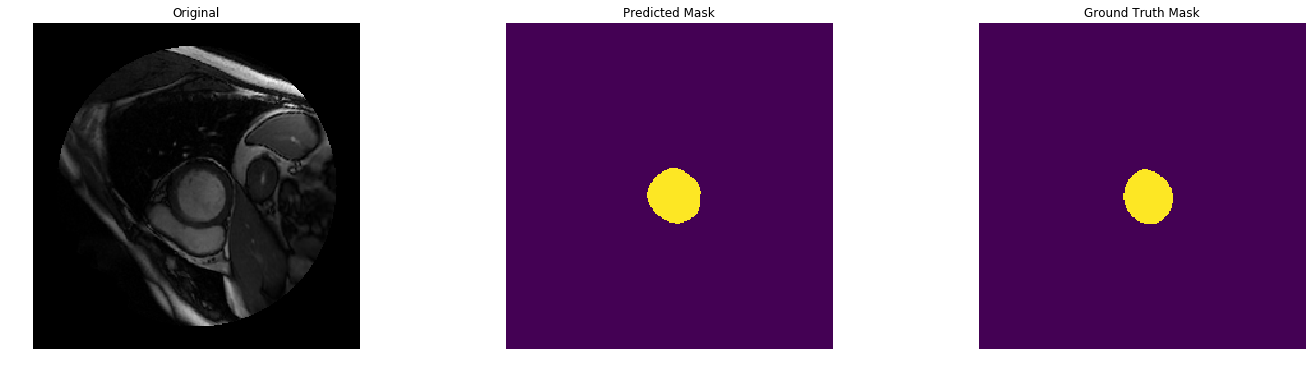

Patient ID: SCD0000201



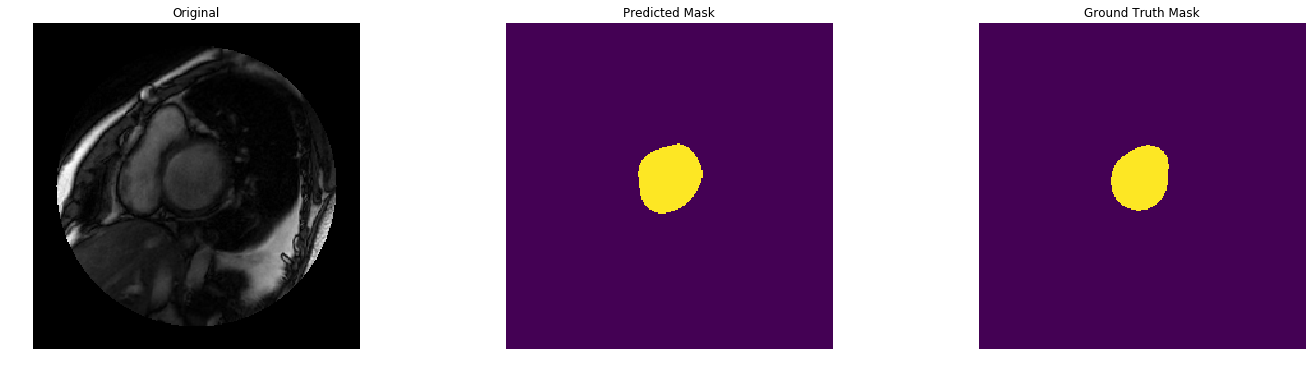

Patient ID: SCD0000301



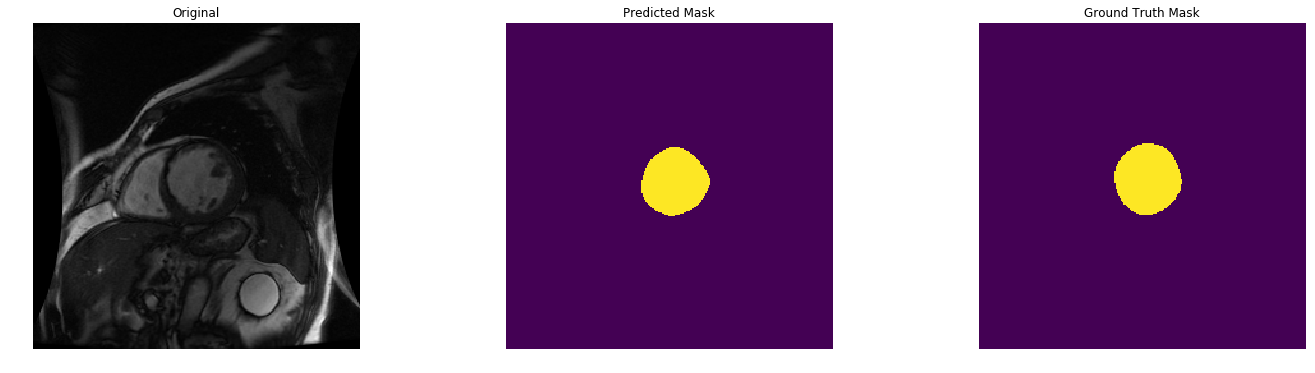

Patient ID: SCD0000401



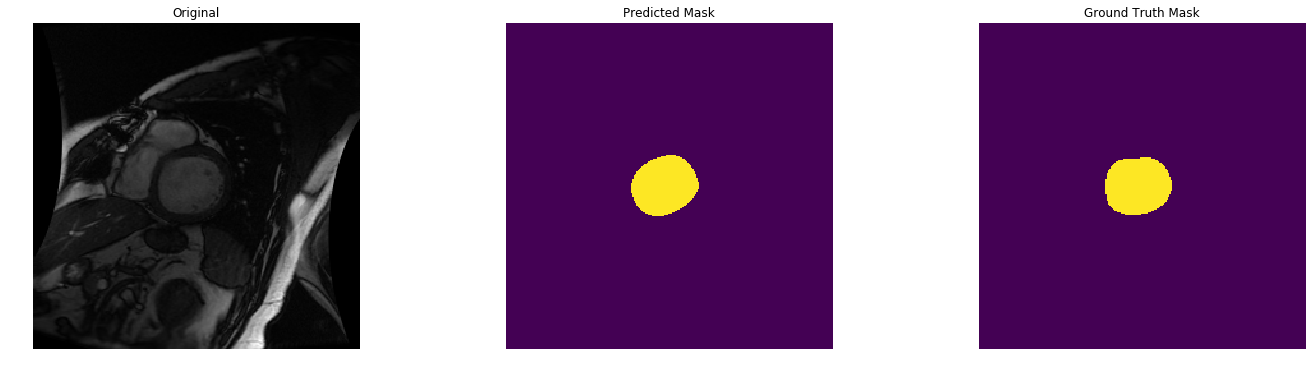

Patient ID: SCD0000501



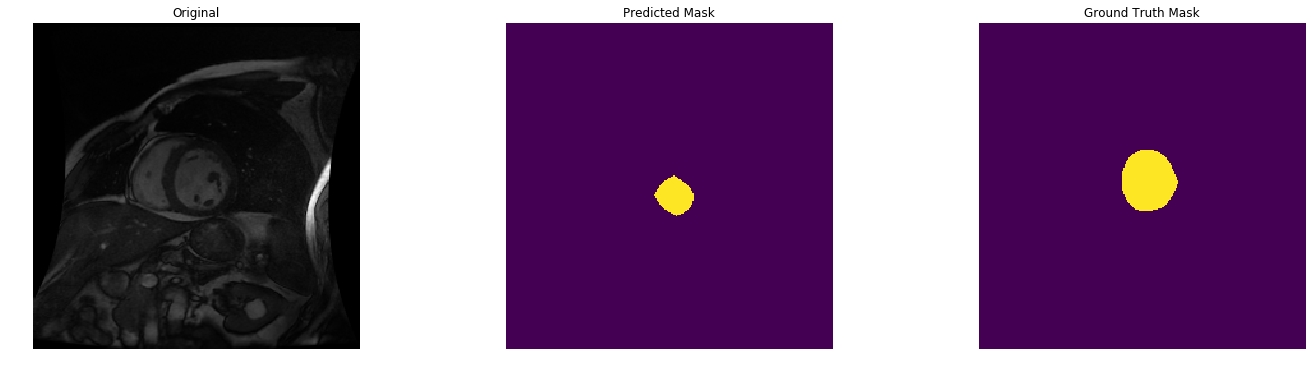

In [6]:
# Remember the first set of results per patient
first_results = []

# Remembers the IoU scores for the alternative method
mean_ious_second_method = []

# For each patient ID...
for patient_id in patient_IDs:
    # Create DICOMLoader for this patient
    # Specify loading in o-contour data
    # and ensure we only load in this patient
    dl = DICOMLoader('data', load_ocontours=True, patient_IDs=[patient_id])
    
    # Set batch size to 1 as we want to see all data
    dl.batch_size = 1
    
    # Set seed so that order is reproducible
    dl.seed = 42
    
    # Get filenames too
    dl.return_filenames_with_batch = True
    
    # Stores the IoUs per patient
    ious = [[None, None]] * len(dl)
    img_to_save = None
    pred_mask_to_save = None
    gt_mask = None
    
    print("======\nPatient ID: {}\n======".format(patient_id))
    
    for i, (imgs, i_masks, o_masks, filenames) in enumerate(dl):
        # Unpack
        img = imgs[0]
        i_mask = i_masks[0]
        o_mask = o_masks[0]
        
        # Normalize for Otsu analysis
        img = (img.astype(np.float) / np.max(img))

        # Make a copy of the outer mask
        o_mask_copy = o_mask.copy()
        
        # Stores the masks per iteration
        masks = [o_mask_copy]
        
        # Stores the means of the intensity around the perimeters
        means = []
        
        # Until there's nothing left to process...
        while o_mask_copy.sum() > 0:
            # Perform erosion
            o_mask_copy = binary_erosion(o_mask_copy, selem=np.ones((3,3),dtype=np.uint16))
            
            # Extract the perimeter
            # We can do this by finding the XOR between the masks
            # where any values that are not equal are the perimeter
            # Areas inside and outside of the contour should be the same
            # except for the perimeter
            perim = masks[-1] != o_mask_copy
            
            # Get the mean intensity along the perimeter
            means.append(np.mean(img[perim]))
            
            # Remember this mask
            masks.append(o_mask_copy)
        
        # Perform Otsu thresholding on the mean intensities
        means = np.array(means) # Ensure we specify a NumPy array
        thresh = threshold_otsu(means)
        
        # Determine the mask that is the closest to the mean intensity that was
        # chosen to be the split point
        idx = np.argmin(np.abs(means - thresh))
        pred_mask = masks[idx]
        
        # Compute IoU
        ious[i] = [filenames[0][0], compute_iou(i_mask, pred_mask)]
        
        # Remember the first result for each patient
        if img_to_save is None and pred_mask_to_save is None and gt_mask is None:
            img_to_save = (255*img).astype(np.uint8)
            pred_mask_to_save = pred_mask.astype(np.float)
            gt_mask = i_mask.astype(np.float)
    
    # Extract out just the values
    iou_vals_new = [v[1] for v in ious]
    
    # Display a table of DICOM image and IoU score
    display(HTML(tabulate.tabulate(ious, tablefmt='html')))
    
    # Add to the list of displaying
    first_results.append((img_to_save, pred_mask_to_save, gt_mask))
    
    # Display mean and standard deviation
    mean_ious_second_method.append(np.mean(iou_vals_new))
    print("Mean of IoUs: {}".format(mean_ious_second_method[-1]))
    print("Standard Deviation of IoUs: {}\n".format(np.std(iou_vals_new)))

# Display the first of each result
for name, (img, pred_mask, gt_mask) in zip(patient_IDs, first_results):
    print("======\nPatient ID: {}\n======\n".format(name))
    f, ax = plt.subplots(1, 3,figsize=(24, 6))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(pred_mask)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    ax[2].imshow(gt_mask)
    ax[2].set_title('Ground Truth Mask')
    ax[2].axis('off')
    plt.show()

Judging from the shape of the predicted masks and the values of the IoU scores for each patient (with the exception of the last one), we can clearly see that the performance has improved.  As one final comparison, let's display the mean IoU scores of each patient for all three methods.

The first column is the patient ID, the second column is the mean IoU score for the patient using the original Otsu method, the third column being the improved Otsu method with the noise removal and hole filling and finally the last column being the morphological erosion combined with Otsu.

In [7]:
final_ious = [(f, a, b, c) for (f, a, b, c) in zip(patient_IDs, mean_ious, mean_ious_new, mean_ious_second_method)]
display(HTML(tabulate.tabulate(final_ious, tablefmt='html')))

The reason why the scores are higher is because we are using *a priori* knowledge of the masks in order to ascertain the predicted mask that delineates the blood pool and so the solution is bounded by the initial mask provided by the *o-contour* mask.  However, if the initial mask is inaccurate then the predicted mask is also inaccurate as one can see from the mean IoU score provided by the last patient.  The advantage of the previous method in this case is that no assumptions are made regarding the spatial coherence of pixels in the mask and are using only the raw intensities.

## Is there an appropriate deep learning-based approach to solve this problem?

The answer to this depends on what ground truth data is available.  If we are able to use both the masks from the *i-contour* and *o-contour* data, then one quick method to try would be using semantic segmentation methods, such as the use of Fully Convolutional Networks by Long *et al.* [3].  The goal of FCNs is to provide a segmentation map creating a pixel-accurate delineation of the different kinds of objects in an image.  In our case, we would be able to use the *i-contour* masks to signify that these blood pool areas belong to one object label, the area in between the *i-contour* and *o-contour* delineations which are the heart muscle areas belong to another object label and everything else to be background.  Given the structure of the `DICOMLoader`, we would be able to successfully feed batches into a FCN architecture so it is able to semantically determine the different areas of our DICOM images.  Of course we will need to do a bit more work to generate the actual ground truth semantic maps that the FCN type framework is expected to receive given the binary masks of the *i-contour* and *o-contour* data.  However, we are only concerned with isolating out the blood pool areas, so all we would have to do is look for the areas that contain just the blood pool label and leave everything else as background.

The reason why it is useful to have both *i-contour* and *o-contour* data is that we would be able to learn a set of filters or feature detectors to specifically look for intensity areas that belong to heart muscles as well as blood pool regions.  This would provide extra information into the training so that the delineation of the blood pool areas is more accurate.  By only using the *o-contour* data (i.e. no *i-contour* data present) would make learning rather ambiguous as using the masks as is would mean that the entire interior of the *o-contour* mask is a single label which is not correct.

For the other case, if we only have access to *o-contour* data we may have to preprocess the data using a heuristical method such as any that were proposed earlier to provide approximate binary masks to the blood pool areas that are interesting, then use those to isolate out approximations of the heart muscle regions.  Using the fact that the data can be erroneous, we would feed these into a FCN type framework and hope that the learned filters that result from training would be robust against errors in the generated ground truth.

## Advantages and Disadvantages of Deep Learning vs. Heuristical Approaches

### Advantages
1. *Requires no heuristical knowledge or feature engineering*.  Provided that the right ground truth data is available, the deep learning framework should be able to learn the right set of filters to specifically look for blood pool or heart muscle regions.
2. *Minimal infrastructure setup is required*.  One can simply use an already established FCN architecture and employ transfer learning to be able to create the right set of filters needed to detect blood pool or heart muscle regions.  The only thing that is really required is the data which is provided from the `DICOMLoader` class.
3. Assuming that both sets of contours are available, *very little knowledge in image processing or computer vision is required*.  In order to come up with the proposed approach, some knowledge about adaptive thresholding and morphology was required.  In other words, coming at this in a heuristical way requires a lot of prior knowledge and most ML practitioners may not have this knowledge.
4. *Inference is fast and operates on the raw pixel data*.  Even though training may take some time, the attractiveness of deep learning frameworks is the fact that inference on unseen data is very fast.  For heuristical approaches, some processing of the images followed by heuristic algorithms must be performed before a decision can be made and this could be a deal breaker when dealing with real-time systems.

### Disadvantages
1. *Training time and computational resources*.  FCN based approaches are known to take a considerable amount of time to train, not only due to the amount of data but to ensure the most optimal performance requires some cross-validation of hyperparameters and fine-tuning which may also require a considerable amount of time.  Heuristic-based approaches require very little computational power and can be used to quickly get results if accuracy is not the most important goal.
2. *Requires a significantly higher amount of data than heuristic-based approaches*.  With heuristic-based approaches, as long as the training set is representative of what is seen in practice, very little data is required to come up with a set of rules that could possibly generalize to unseen data.  With deep-learning based approaches, the more data the better and if there is insufficient data available, techniques such as data imputation are possible but that requires *a priori* knowledge on what kinds of manipulations are required to the original training set to augment it.
3. *The system may require retraining for examples that have widely different characteristics than training*.  When new examples are introduced into the system that may require retraining, it is not intuitive as to how long it would take for retraining to produce the right set of filters that would incorporate this data.  With heuristic-based approaches, some exploratory data analysis as seen at the very beginning of this task are some quick things to try followed by some heuristic set of rules and one can assess whether or not those rules are right quite quickly.  With deep-learning based approaches, it is unclear as to how long the system needs to be trained to incorporate the new samples before assessing the validity of the predicted results.
4. *Must determine the right layers in the architecture to perform transfer learning*.  Applying transfer learning is one thing, but determining which layers to retrain depends entirely on how much data you have and the quality of the data.  This process may also require fine-tuning or experimentation prior to getting good results, and this may take a considerable amount of time.

# References

[1]: Nobuyuki Otsu (1979). "A threshold selection method from gray-level histograms". IEEE Trans. Sys., Man., Cyber. 9 (1): 62–66.  https://ieeexplore.ieee.org/document/4310076/

[2]: "Fill the holes in OpenCV", Accessed on July 2, 2018.  https://stackoverflow.com/questions/1716274/fill-the-holes-in-opencv

[3]: Jonathan Long, Evan Shelhamer and Trevor Darrell (2015). "Fully convolutional networks for semantic segmentation". IEEE CVPR. https://ieeexplore.ieee.org/document/7298965